In [2]:
import pandas as pd
import tkinter as tk
from tkinter import filedialog
from IPython.display import display
import numpy as np
from sklearn.linear_model import LinearRegression
import os
from datetime import datetime

# Paso 0: Preguntar al usuario la moneda de valoración

moneda_valoracion = input("¿En qué moneda deseas valorar los instrumentos? (Ej: CLP, USD): ").strip().upper()
if moneda_valoracion == "":  
    raise ValueError("Debes ingresar una moneda de valoración válida.") 

1. Se usa input(..) para que el usuario pueda escribir "CLP" o "USD" y .strip().upper() elimina espacios al inicio o al final y convierte a mayúsculas.

2. Si el usuario no pone ninguna moneda de valoración el código retornará un error.

--> A partir de aquí toda la valoración se expersará en esa moneda.

In [ ]:
# Paso 1: Seleccionar archivo de forwards

root = tk.Tk()
root.withdraw()
archivo_forwards = filedialog.askopenfilename(
    title="Selecciona el archivo con los forwards", 
    filetypes=[("Excel files", "*.xlsx *.xls")]
)
if not archivo_forwards:
    raise ValueError("No se seleccionó ningún archivo de forwards.")

1. tk.TK() crea una ventana de Tkinter (Necesario para crear la ventana emergente), pero como esto también muestra una ventana principal de Tkinter, se usa root.withdraw() para ocultarla.

2. filedialog.askopenfilename(...) abre un diálogo donde el usuario navega el sistema de archivos y selecciona el Excel de forwards.
        -title: texto que aparece en la barra del diálogo.
        -filetypes: filtro para mostrar solo archivos .xlsx o .xls.

3. Si el usuario cierra el diálogo o presiona cancelar, archivo_forwards queda vacío y arroja un error.

--> Se busca asegurar que se cargue un archivo de forwards.

In [ ]:
# Paso 2: Leer y validar archivo de forwards

columnas_esperadas = [
    'ID', 'Contraparte', 'Inicio', 'Fin', 'Nocional', 'Moneda',
    'Strike', 'Sentido', 'Curva_Activa', 'Curva_Pasiva', 'CDS_Propio', 'CDS_Contraparte', 'Recovery'
]

forwards_df = pd.read_excel(archivo_forwards)
faltantes = set(columnas_esperadas) - set(forwards_df.columns)
if faltantes:
    raise ValueError(f"Faltan columnas en el archivo de forwards: {faltantes}")  # ❸

# Validar que ciertas columnas sean numéricas
for col in ['Nocional', 'Strike', 'CDS_Propio', 'CDS_Contraparte', 'Recovery']:
    if not pd.api.types.is_numeric_dtype(forwards_df[col]):
        raise ValueError(f"La columna '{col}' debe ser numérica.")

# Validar valores de 'Sentido' (solo BUY o SELL)
sentidos_unicos = set(forwards_df['Sentido'].dropna().str.upper().unique())
if not sentidos_unicos.issubset({'BUY', 'SELL'}):
    raise ValueError("La columna 'Sentido' solo puede contener 'BUY' o 'SELL'.")

# Convertir fechas
forwards_df['Inicio'] = pd.to_datetime(forwards_df['Inicio'], errors='raise')
forwards_df['Fin'] = pd.to_datetime(forwards_df['Fin'], errors='raise')

print(f"\n✅ Moneda de valoración: {moneda_valoracion}")
print("✅ Archivo de forwards cargado correctamente:")
display(forwards_df.head())

1. Se definen las columnas esperadas que debería tener el archivo de forwards para que el modelo funcione, es importante que el archivo de inputs de forwards debe tener esas columnas con los nombres tal cual están escrito en el código.

2. Con pd.read_excel(archivo_forwards) carga toda la hoja por defecto (la primera) en el DataFrame forwards_df. Luego se calculan las columnas faltantes si es que aplica, si llegan a faltar columnas el código levantará un error con los nombres de las columnas faltantes.

3. Con for col in ['Nocional', 'Strike', 'CDS_Propio', 'CDS_Contraparte', 'Recovery'], recorremos todas estas columnas y pd.api.types.is_numeric_dtype(...) verifica que cada columna sea de un tipo numérico (int, float). Si alguna no es numérica, el código arrojará un error con el nombre de la columna que no es numérica.

4. Con Sentidos_unicos tomamos la columna forwards_df['Sentido'], quitamos NaN con .dropna(), convertimos todo a mayúsculas .str.upper() y extraemos valores únicos .unique(). Luego, se compara si dicho conjunto está dentro de "Buy" o "Sell", si aparece otro valor dentro del conjunto, el chequeo falla y lanzamos error para forzar que sólo exista una de esas dos opciones.

5. Por último con pd.to_datetime(..., errors='raise') convertimos las columnas 'Inicio' y 'Fin' a tipo datetime64[ns]. Si algún valor no puede pconvertirse a ese tipo de fecha, el código arroja un error. Esto sirve para posteriormente restar fechas fácilmente y calcular días hasta el vencimiento.

--> Este bloque de código busca comprobar que el archivo de inputs contractuales de los forwards tenga toda la información necesaria para el modelo y hace transformaciones necesarias para los datos de este.

In [ ]:
# Paso 3: Identificar monedas únicas y relacionadas

monedas_unicas = forwards_df['Moneda'].unique().tolist()
# Asegurarnos de que la moneda de valoración esté en la lista
if moneda_valoracion not in monedas_unicas:
    raise ValueError(f"La moneda de valoración '{moneda_valoracion}' no aparece en la columna 'Moneda' del archivo.")

monedas_relacionadas = [m for m in monedas_unicas if m != moneda_valoracion]  # lista en lugar de set
# Genéricos de nombres de hojas FX (las validaremos luego)
relaciones_tc = [f"TC_{m}{moneda_valoracion}W" for m in monedas_relacionadas]

1. forwards_df['Moneda'].unique() extrae el arreglo de monedas que aparecen en la columna “Moneda” (por ejemplo, ['USD','CLP']).

2. Se Verifica que la moneda_valoracion efectivamente exista en esa lista. Si no, no podemos continuar porque no hay un forward en la misma moneda de valoración.

3. monedas_relacionadas es la lista de todas las monedas distintas de la moneda_valoracion. Si “Moneda” en los forwards es ['USD','CLP','EUR'] y elegiste “CLP”, entonces monedas_relacionadas = ['USD','EUR'].

4. relaciones_tc arma el nombre de las hojas Excel donde se espera encontrar las series de tipo de cambio. Por ejemplo, si moneda_valoracion='CLP' y m='USD', la hoja esperada es "TC_USDCLPW". Más adelante el código validará si esa hoja existe.

--> El objetivo de este bloque de código es poder identificar que monedas se necesitan simular en FX y preparar nombres de hojas para leer los históricos.

In [ ]:
# Paso 4: Seleccionar archivo de insumos varios

archivo_insumos = filedialog.askopenfilename(
    title="Selecciona el archivo con curvas, tipos de cambio y tasas",
    filetypes=[("Excel files", "*.xlsx *.xls")]
)
if not archivo_insumos:
    raise ValueError("No se seleccionó ningún archivo de insumos.")  # ❽

xls_insumos = pd.ExcelFile(archivo_insumos)

# Diccionarios para guardar inputs

curvas_descuento = {}   # Guardará DataFrames con 'Days' y 'Zero Rate'
datos_fx = {}           # Guardará Series de precios FX indexadas por fecha
tasas_historicas = {}   # Guardará Series de tasas históricas (en decimales)

1. Igual que en el paso 1, se abre un diálogo para que el usuario pueda seleccionar el Excel que debe contener lo siguiente:

   -Una hoja por moneda para cada curva de descuento a la fecha de valoración (Tiene que tener nombre que siga el siguiente patrón "Desc_Moneda"). Por ejemplo si tienes forwards con monedas distintas "USD" y "CLP", deberías tener dos hojas una con la curva de descuento para la moneda USD al 31.12.2024 y con nombre "Desc_USD" y otra con lo mismo pero para la moneda CLP y con nombre "Desc_CLP". Por último esta hoja debe tener dos columnas una que se llame "Days" con los días y otra "Zero Rate" con la tasa.

   -Una hoja con la serie histórica de tasas de las monedas únicas, con nombre libre ya que el código te preguntará el nombre de las hojas, es importante que la serie de tasas tenga dos columnas, una con la fecha y la otra con la tasa en formato decimal, es decir, si la tasa es del 3,5% que aparezca como 3,5.

   -Series de tipo de cambio (hojas con nombre “TC_<moneda><moneda_valoracion>W” o su inversa). Es decir, puede llamarse "TC_USDCLPW" o "TC_CLPUSDW", el código entenderá que son lo mismo. Es importante que que tenga dos columnas "Date" con la fecha y "Price" con el TC.

2. Si el usuario no elige nada, el código lanza un error.

3. Por último se crea un diccionario para guardar todos los datos leídos.

--> El objetivo es consolidar en un solo archivo todos los inputs necesarios para el modelo.

In [ ]:
# Paso 5: Leer curvas y tasas por moneda

for moneda in monedas_unicas:
    print(f"\n--- Procesando insumos para moneda: {moneda} ---")

    # 5.1: Cargar curva de tasas actual (hoja "Desc_<MONEDA>")
    hoja_curva = f"Desc_{moneda}"
    if hoja_curva not in xls_insumos.sheet_names:
        raise ValueError(f"No se encontró la hoja '{hoja_curva}' en el archivo de insumos.")  # ⓬

    curva_df = pd.read_excel(xls_insumos, sheet_name=hoja_curva)
    if not {'Days', 'Zero Rate'}.issubset(curva_df.columns):
        raise ValueError(f"La hoja '{hoja_curva}' debe tener columnas: 'Days' y 'Zero Rate'")  # ⓭

    # Forzar tipos correctos
    curva_df = curva_df[['Days', 'Zero Rate']].copy()
    curva_df['Days'] = curva_df['Days'].astype(int)
    curva_df['Zero Rate'] = curva_df['Zero Rate'].astype(float)

    curvas_descuento[moneda] = curva_df

    # 5.2: Cargar tasas históricas (el usuario elige la hoja)
    print(f"Hojas disponibles: {xls_insumos.sheet_names}")
    hoja_tasa = input(f"Ingresa el nombre de la hoja con tasas históricas para {moneda}: ").strip()
    if hoja_tasa not in xls_insumos.sheet_names:
        raise ValueError(f"No se encontró la hoja '{hoja_tasa}' en el archivo de insumos.")  # ⓯

    df_tasa = pd.read_excel(xls_insumos, sheet_name=hoja_tasa)
    if not {'Date', 'Rate'}.issubset(df_tasa.columns):
        raise ValueError(f"La hoja '{hoja_tasa}' debe tener columnas 'Date' y 'Rate'")  # ⓰

    # Parseo y orden
    df_tasa['Date'] = pd.to_datetime(df_tasa['Date'], errors='raise')
    df_tasa = df_tasa.sort_values('Date').set_index('Date')
    # Convertir a decimal (de %, p. ej. 3.5 → 0.035)
    serie_tasas = pd.to_numeric(df_tasa['Rate'], errors='coerce').dropna() / 100
    tasas_historicas[moneda] = serie_tasas

1. 5.1 :Para cada moneda en monedas_unicas (p.ej. "USD", "CLP", "EUR"):
   -Se monta hoja_curva = f"Desc_{moneda}".

   -Si esa hoja no existe en xls_insumos.sheet_names, lanzamos error. Es obligatorio que el Excel tenga una hoja llamada exactamente “Desc_USD”, “Desc_CLP”, etc.

   -pd.read_excel(xls_insumos, sheet_name=hoja_curva) carga esa hoja a curva_df.

   -Luego el código verifica que curva_df contenga las columnas 'Days' y 'Zero Rate'.
   
   -Se fuerza a que 'Days' sea entero y 'Zero Rate' float. Construimos una copia limpia curva_df[['Days','Zero Rate']].copy().
   
   -Se asigna curvas_descuento[moneda] = curva_df. Así, todas las curvas quedan guardadas para su posterior uso.

2. 5.2: Se imprime print(f"Hojas disponibles: {xls_insumos.sheet_names}") para que el usuario vea todas las hojas y escriba correctamente el nombre de la que contiene la serie histórica de tasas para esa moneda.

  -hoja_tasa = input(...) le pide al usuario el nombre exacto de la hoja (por ejemplo, “Tasas_USD_5Años”). Si no existe, error.
  
  -df_tasa = pd.read_excel(xls_insumos, sheet_name=hoja_tasa) carga la hoja completa. Se Verifica que df_tasa tenga exactamente las columnas 'Date' y 'Rate'.
  
  -Se convierte 'Date' a datetime64 y ordenamos cronológicamente por fecha (.sort_values('Date')). Luego hacemos .set_index('Date') para indexar por fecha.
  
  -Luego se toma la columna 'Rate', convertimos a numérico con pd.to_numeric(...).dropna(), y dividimos por 100 para pasar de porcentaje a decimal (por ejemplo, 3.5 → 0.035).
  
  -Por último, se guarda en tasas_historicas[moneda] = serie_tasas.

--> Esas series sirven para calibrar el modelo de Vasicek. Con las tasas históricas diarias/semanales/semestrales, calculamos los parámetros 𝑎,𝑏,𝜎. Deben estar en decimales desde ahora en adelante.

In [ ]:
# Paso 6: Leer históricos de tipo de cambio si aplica

for moneda in monedas_relacionadas:
    relacion_directa = f"TC_{moneda}{moneda_valoracion}W"
    relacion_inversa = f"TC_{moneda_valoracion}{moneda}W"

    if relacion_directa in xls_insumos.sheet_names:
        hoja_tc, invertir = relacion_directa, False
    elif relacion_inversa in xls_insumos.sheet_names:
        hoja_tc, invertir = relacion_inversa, True
    else:
        raise ValueError(
            f"No se encontró hoja de tipo de cambio para {moneda} ni como "
            f"'{relacion_directa}' ni como '{relacion_inversa}'."
        ) 

    df_fx = pd.read_excel(xls_insumos, sheet_name=hoja_tc)
    if not {'Date', 'Price'}.issubset(df_fx.columns):
        raise ValueError(f"La hoja '{hoja_tc}' debe tener columnas 'Date' y 'Price'")  # ⓴

    df_fx['Date'] = pd.to_datetime(df_fx['Date'], errors='raise')
    df_fx = df_fx.sort_values('Date').set_index('Date')
    # Convertir a float y remover NaN
    serie_tc = pd.to_numeric(df_fx['Price'], errors='coerce').dropna()
    if invertir:
        serie_tc = 1 / serie_tc

    datos_fx[moneda] = serie_tc

print("\n✅ Todos los insumos fueron cargados exitosamente.")

1. El código recorre cada moneda en monedas_relacionadas (p.ej. si valoramos en “CLP”, pueden ser ['USD','EUR', …]).

2. Se construye dos nombres posibles de hoja: relacion_directa = "TC_USDCLPW", relacion_inversa = "TC_CLPUSDW". Esto cubre el caso de que el Excel tenga la cotización directa (por ej. “1 USD = X CLP”) o la inversa (por ej. “1 CLP = Y USD”).

3. Si ni "TC_USDCLPW" ni "TC_CLPUSDW" están en xls_insumos.sheet_names, se lanza un error: necesitamos los datos FX para poder convertir a moneda de valoración.

4. Si se encuentra la forma directa, invertir=False. Si se encuentra sólo la forma inversa, invertir=True.

5. df_fx = pd.read_excel(xls_insumos, sheet_name=hoja_tc) lee la hoja correspondiente. Se verifica que esa hoja tenga columnas 'Date' y 'Price'. En FX, “Price” es el tipo de cambio en la fecha dada.

6. Se convierte 'Date' a datetime64, ordenamos con .sort_values('Date'), y set_index('Date') para indexar por fecha.

7. serie_tc = pd.to_numeric(df_fx['Price'], errors='coerce').dropna() garantiza que todos los valores de “Price” sean floats y eliminamos filas nulas.

9. Finalmente se guarda datos_fx[moneda] = serie_tc, donde la llave es, digamos, "USD". Esa serie temporal se usará para anclar la simulación del FX y calcular estadísticas históricas de volatilidad.

--> Valida la serie de tipos de cambios históricos para las monedas relacionadas y así poder aplicar cholesky para las simulaciones.

In [ ]:
# Paso 7: Definir parámetros globales de simulación para EAD
num_simulaciones = 1000
num_pasos = 12
horizonte_anios = 1.0
dt_sim = horizonte_anios / num_pasos  
dt_calib = 1/252

print(f"\n📌 Parámetros de simulación definidos:")
print(f"  Simulaciones: {num_simulaciones}")
print(f"  Pasos de tiempo: {num_pasos}")
print(f"  Tamaño de paso para simulación (dt_sim): {dt_sim:.4f} años")

1. Este bloque busca definir los parámetros generales para todas las simulaciones que se harán a partir de este punto, es importante que se ajusten de acuerdo a las necesidades de cada simulación.

2. num_simulaciones son el total de trayectorias montecarlo que se harán para cada instrumento.

3. num_pasos son los stopping times en los que la simulación se parará para evaluar la exposición esperada.

4. horizonte_anios es el horizonte en años total de la simulación.

5. dt_sim paso del tiempo en años para la simulación (drift FX y Vasicek en EAD). Uso posterior:

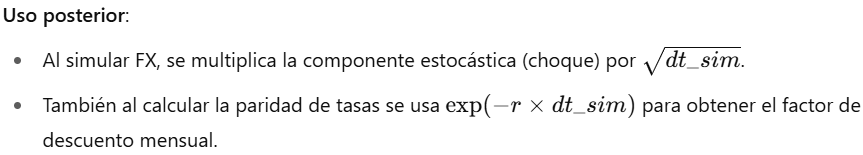

6. dt_calib es el paso de tiempo para calibrar Vasicek, dado que los datos históricos de las tasas están en días hábiles se usa 1/252, si se tuvieran datos semanales o mensuales se tendría que ajustar este parámento. Lo importante es que dt_calib refleje la preiodicidad de las observaciones usadas para calibrar.

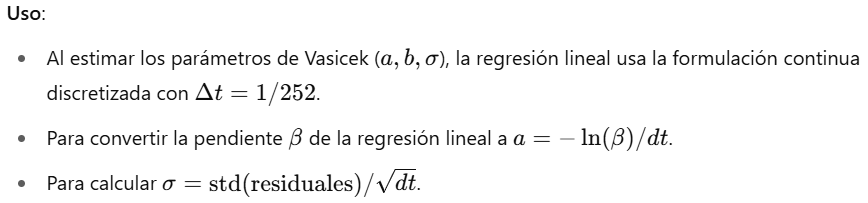

--> Con este bloque de código se calibran las simulaciones del modelo

In [ ]:
# Paso 8: Calibrar Vasicek

parametros_vasicek = {}

for moneda, serie_tasas in tasas_historicas.items():
    print(f"\n--- Calibrando Vasicek para {moneda} ---")

    # 1) Validar que haya al menos dos datos
    if len(serie_tasas) < 2:
        raise ValueError(f"La serie de tasas históricas para {moneda} debe tener al menos 2 datos.")

    # 2) La serie ya está en decimales (0.035 en lugar de 3.5)
    r_array = serie_tasas.values

    # 3) Crear r_t y r_{t+1}
    r_t  = r_array[:-1]
    r_t1 = r_array[1:]

    # 4) Ajustar regresión lineal: r_{t+1} = α + β * r_t + ε
    X = r_t.reshape(-1, 1)
    y = r_t1.reshape(-1, 1)
    modelo = LinearRegression().fit(X, y)

    # 5) Extraer correctamente el único coeficiente e intercepto
    beta  = modelo.coef_[0, 0]
    alpha = modelo.intercept_[0]

    # 6) Definir dt_calib para datos diarios
    dt_calib = 1.0 / 252.0

    # 7) Calcular parámetros a y b del proceso Vasicek
    a = -np.log(beta) / dt_calib
    b = alpha / (1.0 - beta)

    # 8) Calcular sigma usando desvío de residuales anualizado
    residuales = (y - modelo.predict(X)).flatten()
    sigma = np.std(residuales, ddof=0) / np.sqrt(dt_calib)

    parametros_vasicek[moneda] = {'a': a, 'b': b, 'sigma': sigma}
    print(f"a={a:.6f}, b={b:.6f}, sigma={sigma:.6f}")

1. Se crea un diccionario vacío parametros_vasicek que guardará, para cada moneda, los parámetros (𝑎,𝑏,𝜎)del modelo.

2. Se recorre tasas_historicas.items(), donde serie_tasas es una Serie de pandas indexada por fecha, con valores de tipo tasa en decimales (p.ej. 0.035 para 3.5 %). Antes de calibrar se tiene que asegurar el código de que la serie debe tener al menos 2 observaciones para poder aplicar la regresión lineal.

3. Luego, se extraen los valores crudos de la Serie en un arreglo NumPy r_array. Cada elemento es la tasa diaria en decimal (p.ej, 0.035).

4. 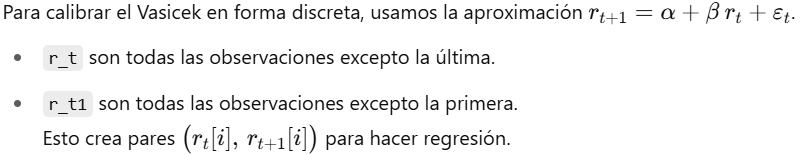

------------------------------------------------------------------------------------------------------------------------------------------------

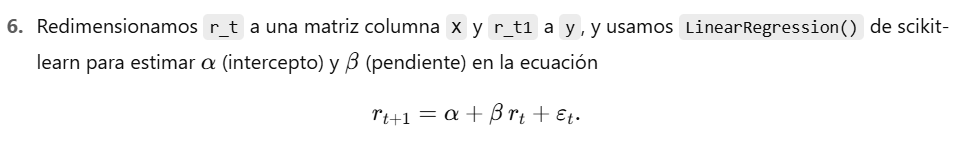

5. Tras el fit, modelo.coef_ es un arreglo 1×1 (porque solo hay una variable predictora). Tomamos ese valor como 𝛽.modelo.intercept_ es un arreglo de longitud 1; lo extraemos como escalar 𝛼.

6. dt_calib define los días hábiles al año 1/252.

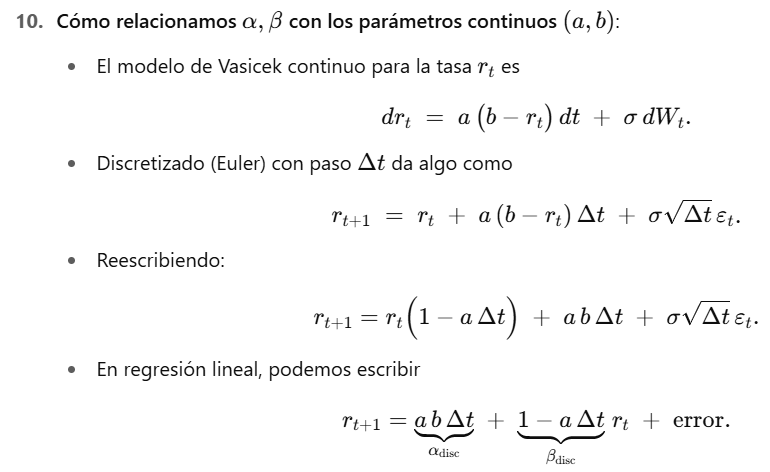

------------------------------------------------------------------------------------------------------------------------------------------------

   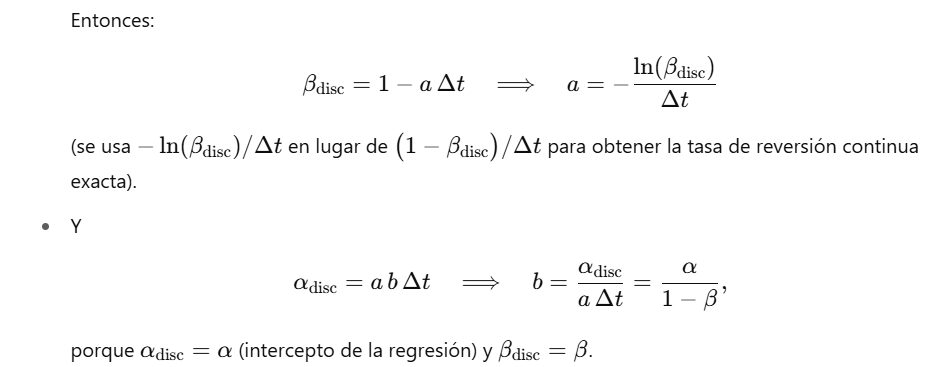

------------------------------------------------------------------------------------------------------------------------------------------------

   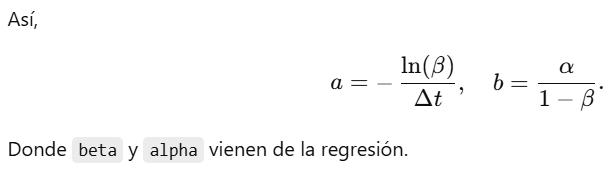

7. residuales = y - modelo.predict(X) son los errores 𝜀𝑡 de la regresión en escala discreta. np.std(residuales, ddof=0) calcula la desviación estándar muestral de esos residuales (en la misma unidad que 𝑟).

------------------------------------------------------------------------------------------------------------------------------------------------

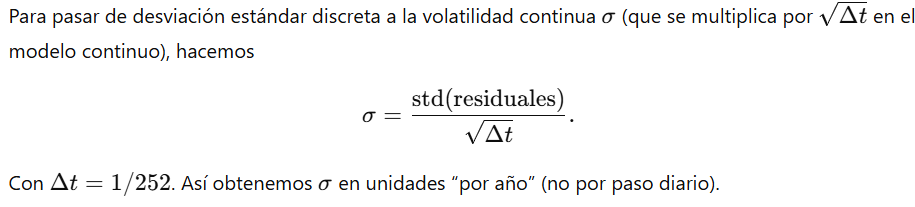

8. Por último, en el diccionario parametros_vasicek un sub-diccionario con los valores {𝑎, 𝑏, 𝜎} para esa moneda.

------------------------------------------------------------------------------------------------------------------------------------------------

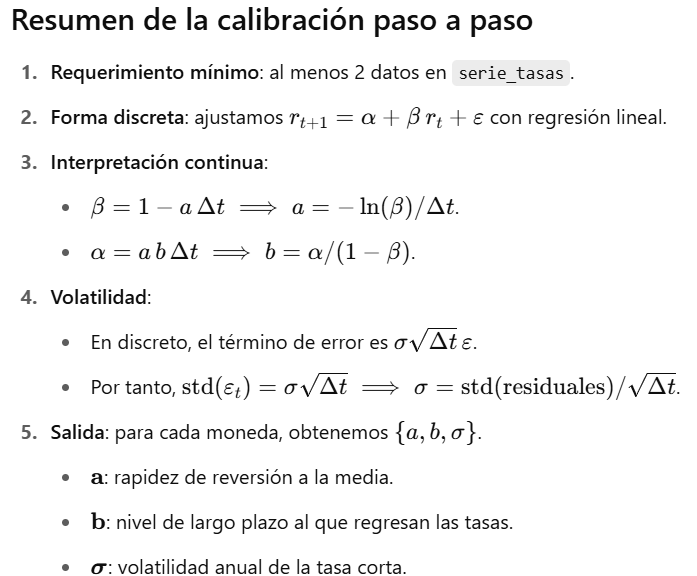




In [ ]:
# Paso 9: Construir matriz de shocks históricos

# ❶ --- 1) Preparar las series de tasas en decimales y calcular diferencias (Δ) ---

# En lugar de asumir solo CLP y USD, iteramos sobre todas las monedas disponibles:
shocks_list = []
nombres_vars = []

for moneda, serie in tasas_historicas.items():
    # ❷ La serie ya está en decimales (e.g., 0.035 en lugar de 3.5)
    #     Directamente calculamos la diferencia
    diff = serie.diff().dropna().rename(f"d{moneda}")
    shocks_list.append(diff)
    nombres_vars.append(f"d{moneda}")

# ❸ --- 2) Calcular log-retornos de cada serie FX (moneda vs moneda_valoracion) ---

for moneda_fx, serie_fx in datos_fx.items():
    # Convertimos a float y eliminamos NaN
    fx_clean = pd.to_numeric(serie_fx, errors='coerce').dropna()
    logret = np.log(fx_clean).diff().dropna().rename(f"logRet_{moneda_fx}{moneda_valoracion}")
    shocks_list.append(logret)
    nombres_vars.append(f"logRet_{moneda_fx}{moneda_valoracion}")

# ❹ --- 3) Alinear todas las series en un único DataFrame y eliminar filas con NaN ---

df_shocks = pd.concat(shocks_list, axis=1).dropna()

# ❺ --- 4) Calcular covarianza, correlación y matriz de Cholesky ---

cov_matrix = df_shocks.cov()
# Correlación implícita:
corr = cov_matrix / np.sqrt(np.outer(np.diag(cov_matrix), np.diag(cov_matrix)))

print("\nCorrelación implícita:")
print(corr)

print("\n📈 Matriz de covarianza (tasas en Δ y log-retornos FX):")
print(cov_matrix)

# Cholesky (nota: cov_matrix tiene dimensión len(nombres_vars)×len(nombres_vars))
cholesky_matrix = np.linalg.cholesky(cov_matrix.values)
print("\n🧮 Matriz de Cholesky:")
print(cholesky_matrix)

1. Preparar las series de tasas en decimales y calcular diferencias (Δ):

   -tasas_historicas es un diccionario donde cada llave “moneda” (por ejemplo, "USD", "CLP", "EUR", etc.) apunta a una Serie de pandas indexada por fecha, con valores que ya están en decimales (0.035=3.5%).
   
   -Al iterar for moneda, serie in tasas_historicas.items(), cada serie es esa Serie de tasas.
   
   -serie.diff() calcula la diferencia diaria Δ𝑟𝑡 = 𝑟𝑡 − 𝑟𝑡−1. Como ya está en decimales, Δrt queda también en unidades de tasa (por ejemplo, 0.0001 = 0.01 %) por día.
   
   -.dropna() elimina el primer valor (porque diff() deja NaN en la primera fila) y cualquier NaN adicional.
   
   -.rename(f"d{moneda}") le da nombre a la Serie resultante, p.ej. "dUSD" o "dCLP".
   
   -A cada Serie de diferencias la agregamos a la lista shocks_list y registramos su nombre en nombres_vars. Así, shocks_list = [dUSD, dCLP, dEUR, …], nombres_vars = ["dUSD", "dCLP", "dEUR", …]

   --> Se busca capturar cómo varían históricamente las tasas cortas de cada moneda de forma homogénea (todos en decimal). Esa variación diaria se usará luego como “shock” de mercado al simular Vasicek en forward.

2. Calcular log-retornos de cada serie FX (moneda vs moneda_valoracion):

   -datos_fx es un diccionario donde la llave "USD" apunta a la Serie histórica de precios USD→CLP (por ejemplo). Si tu moneda de valoración fuera “CLP”, querrás logRet_USDCLP. Si tu moneda de valoración fuera “USD” y hay un "CLP" en datos_fx, querrías logRet_CLPUSD, etc.

   -datos_fx es un diccionario donde la llave "USD" apunta a la Serie histórica de precios USD→CLP (por ejemplo). Si tu moneda de valoración fuera “CLP”, querrás logRet_USDCLP. Si tu moneda de valoración fuera “USD” y hay un "CLP" en datos_fx, querrías logRet_CLPUSD, etc.

   -Dentro del bucle, serie_fx es la Serie de precios indexados por fecha. Hacemos: pd.to_numeric(serie_fx, errors='coerce').dropna() para asegurarnos de que todos los valores sean floats, y eliminar NaN. np.log(fx_clean).diff().dropna() calcula el log‐retorno diario: 
   logRet =  ln(St) − ln(St−1).

   -.rename(f"logRet_{moneda_fx}{moneda_valoracion}") le da nombre, p.ej. "logRet_USDCLP". Luego se agrega esta Serie de log‐retornos a shocks_list y su nombre a nombres_vars.

   --> Se busca que para cada moneda distinta de la de valoración (en datos_fx), queremos el log‐retorno diario ln(𝑆𝑡/𝑆𝑡−1), que se usará como “shock” del tipo de cambio en la simulación.

3. Alinear todas las series en un único DataFrame y eliminar filas con NaN

   -En shocks_list hasta ahora hay:
      -Series de diferencias de tasas: dUSD, dCLP, dEUR, …
      -Series de log‐retornos FX: logRet_USDCLP, logRet_EURCLP, …
   
   -pd.concat(shocks_list, axis=1) las agrupa en un mismo DataFrame de pandas, donde cada serie es una columna. Se usa el índice de fecha: las filas solo permanecen en aquellas fechas (días) donde al menos una Serie estaba presente. Pueden quedar NaN donde alguna Serie no tenía valor en una fecha concreta.

   -.dropna() elimina cualquier fila con al menos un NaN, forzando que solo queden fechas en las que todas las Series (dXXX y logRet_YYY) tengan valor. Esto “alinea” todas las columnas para que tengan exactamente el mismo rango de fechas.

   -El DataFrame resultante df_shocks tiene dimensión (n_días, n_vars), con n_vars = len(monedas_unicas) + len(monedas_relacionadas).

4.  Calcular covarianza, correlación y matriz de Cholesky

   -df_shocks.cov() calcula la matriz de covarianza entre todas las columnas (diferencias de tasas y log‐retornos FX).
   
   -Cada entrada cov_matrix.loc["dUSD","dCLP"] por ejemplo, es
   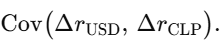

   -np.diag(cov_matrix) devuelve el vector de varianzas de cada columna.

   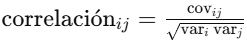

   -El cálculo manual con np.sqrt(np.outer(...)) da exactamente esa correlación. Se imprime el DataFrame corr para ver cómo se correlacionan shocks de tasas y shocks de FX en el histórico.

   -Para simular shocks correlacionados, necesitamos una matriz 𝐿 tal que 𝐿𝐿⊤ = Σ , donde Σ es la matriz de covarianza.np.linalg.cholesky(cov_matrix.values) produce esa 𝐿.
   
   -Cada fila de 𝐿 corresponderá a cómo mezclar variables independientes estándar normales para obtener las correlaciones históricas.
   
   -Se imprime cholesky_matrix para verificar numéricamente la descomposición.

   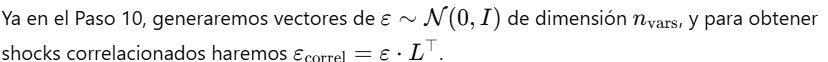

   -De esta forma, las simulaciones tendrán exactamente la estructura de covarianzas que se tiene en el histórico.

   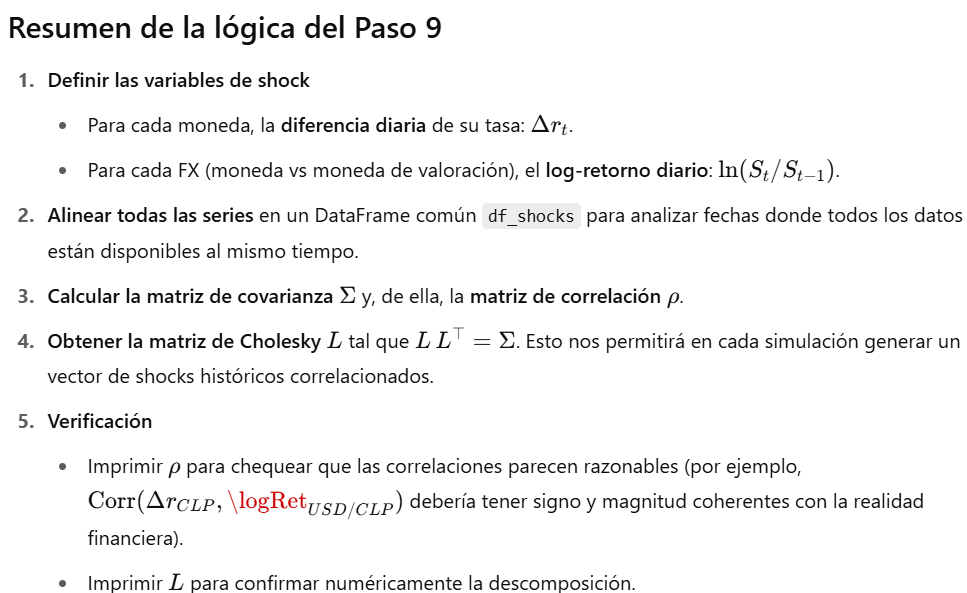



In [ ]:
# Paso 10: Simulación de tasas por moneda usando Vasicek + Cholesky

# ❶ Establecer semilla para reproducibilidad
np.random.seed(1)

# ❷ Parámetros de dimensión
num_monedas = len(monedas_unicas)
num_fx = len(monedas_relacionadas)
num_vars = num_monedas + num_fx  # variables = Δtasas (una por moneda) + log-retornos FX

# ❸ Estructura para guardar simulaciones de tasas
simulaciones_tasas = {
    m: np.zeros((num_simulaciones, num_pasos + 1))
    for m in monedas_unicas
}

# ❹ Obtener tasas iniciales desde la curva actual (ya en % → en fracción)
tasas_iniciales = {
    m: curvas_descuento[m].iloc[0]['Zero Rate'] / 100
    for m in monedas_unicas
}

# ❺ Construir lista de nombres de variables en el mismo orden que Cholesky
#    Primero, las tasas ("d<MONEDA>"); luego, cada FX como "logRet_<MONEDA><moneda_valoracion>"
nombres_vars = [f"d{m}" for m in monedas_unicas] + [
    f"logRet_{m}{moneda_valoracion}" for m in monedas_relacionadas
]

# ❻ Generar shocks independientes y aplicar Cholesky de una sola vez
#    ε shape = (num_simulaciones, num_pasos, num_vars)
epsilon = np.random.standard_normal(size=(num_simulaciones, num_pasos, num_vars))
#    shocks_corr = ε × chol.T → shape = (num_simulaciones, num_pasos, num_vars)
shocks_correlacionados = np.einsum('ijk,lk->ijl', epsilon, cholesky_matrix.T)

# ❼ Construir diccionario que asocia cada moneda con su índice en “nombres_vars”
indice_moneda = {
    m: nombres_vars.index(f"d{m}")
    for m in monedas_unicas
}

# ❽ Definir dt para simulación mensual (1 año dividido en num_pasos)
dt_sim = horizonte_anios / num_pasos

# ❾ Simular tasas Vasicek
for m in monedas_unicas:
    a = parametros_vasicek[m]['a']
    b = parametros_vasicek[m]['b']
    sigma = parametros_vasicek[m]['sigma']
    r0 = tasas_iniciales[m]
    idx = indice_moneda[m]

    for sim in range(num_simulaciones):
        simulaciones_tasas[m][sim, 0] = r0  # condición inicial
        for t in range(1, num_pasos + 1):
            r_prev = simulaciones_tasas[m][sim, t - 1]
            Z = shocks_correlacionados[sim, t - 1, idx]
            # Ecuación de Vasicek discretizada (Euler-Maruyama)
            r_t = r_prev + a * (b - r_prev) * dt_sim + sigma * np.sqrt(dt_sim) * Z
            # Evitar tasas negativas truncando a un valor mínimo pequeño
            simulaciones_tasas[m][sim, t] = r_t

# ❿ Diagnóstico de una trayectoria (simulación 0, primeros pasos)
print("\nChequeo de simulaciones de tasas (simulación 0)")
for m in monedas_unicas:
    print(f"{m}: {simulaciones_tasas[m][0, :5]}")  # pasos 0–4

1. Establecer semilla para reproducibilidad: 

   -Fijar la semilla (seed=1) garantiza que, cada vez que ejecutes este bloque, los números aleatorios (y por ende las simulaciones) sean los mismos. Así se puede comparar resultados entre corridas o depurar sin variaciones debidas a la aleatoriedad.

2. Parámetros de dimensión: 

   -num_monedas es la cantidad de monedas para las que calibraste Vasicek (p. ej. ['USD','CLP','EUR'] → 3). 

   -num_fx es la cantidad de pares FX que necesitas simular, es decir, todas las monedas distintas de la de valoración (p. ej. si valoras en CLP y tienes ['USD','EUR'], entonces num_fx=2). 

   -num_vars = num_monedas + num_fx es el total de variables de choque simultáneo: cada moneda aporta un “Δr” (diferencia de tasa) y cada par FX aporta un “logRet”. Más adelante se usa exactamente este num_vars para indexar en la matriz de Cholesky de dimensión (num_vars × num_vars).

3. Estructura para guardar simulaciones de tasas:
   
   -Se crea un diccionario simulaciones_tasas con una clave por cada moneda (m en monedas_unicas).

   -Cada valor es un array NumPy de tamaño (num_simulaciones, num_pasos+1).
   
   -El eje 0 (filas) indexa la simulación número 0, 1, …, num_simulaciones-1.
   
   -El eje 1 (columnas) indexa los pasos de tiempo 𝑡 = 0, 1, …, num_pasos.
   
   -Inicialmente, todo está en ceros. Luego, en el bucle de simulación, llenaremos cada posición [sim,t] con la tasa simulada en el paso 𝑡 de la simulación sim.

4. Obtener tasas iniciales desde la curva actual:
   
   -Para cada moneda m, vamos a extraer de curvas_descuento[m] (DataFrame con las columnas 'Days' y 'Zero Rate') el valor de la tasa “corta” a tiempo 0.
   
   -curvas_descuento[m].iloc[0]['Zero Rate'] asume que la primera fila corresponde al tenor más corto (por típico, “1 día” o “overnight”).
   
   -Como esa tasa estaba en porcentaje (p. ej. 3.5), la dividimos por 100 para pasarla a decimal (0.035).
   
   -Guardamos en tasas_iniciales[m] ese valor, que se usará como condición inicial 𝑟0 para el Vasicek de la moneda m.

5. Construir lista de nombres de variables en el mismo orden que Cholesky

   -Construimos explícitamente la lista nombres_vars en el mismo orden en que concatenamos las Series en df_shocks (Paso 9).
   
   -Primero van todas las columnas de “dTASA” en el orden de monedas_unicas (p. ej. ["dUSD","dCLP","dEUR"]).
   
   -Luego van todas las columnas de “logRet” para cada FX, en el mismo orden de monedas_relacionadas (por ejemplo si moneda_valoracion="CLP", serían ["logRet_USDCLP","logRet_EURCLP"]).

   -Esa lista nombres_vars asegura que, si en el Paso 9 al concatenar hicimos df_shocks.columns = nombres_vars, entonces la matriz de covarianza y su Cholesky corresponden exactamente a este orden. Más adelante usaremos el índice dentro de nombres_vars para saber “en qué posición” está el shock de la tasa de cada moneda.

6. Generar shocks independientes y aplicar Cholesky de una sola vez:

   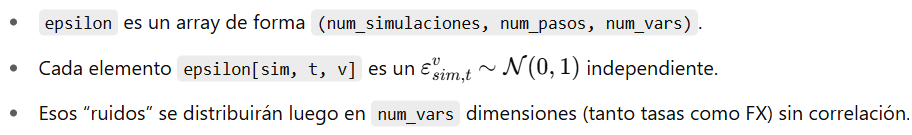

------------------------------------------------------------------------------------------------------------------------------------------------

   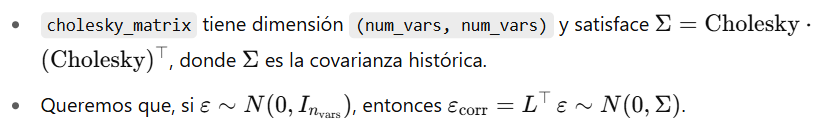

   -La línea shocks_correlacionados = np.einsum('ijk,lk->ijl', epsilon, cholesky_matrix.T) equivale hacer para cada simulación "sim" y paso "t": shocks_correlacionados[sim,t,:] = epsilon[sim,t,:] @ cholesky_matrix.T. Con lo cual la última dimensión (v = 0..num_vars−1) queda correlacionada de acuerdo a cholesky_matrix.

   -El resultado shocks_correlacionados tiene la misma forma (num_simulaciones, num_pasos, num_vars), pero ahora la covarianza interna de la última dimensión es Σ.

7. Construir diccionario que asocia cada moneda con su índice en “nombres_vars”:

   -Generamos indice_moneda, un diccionario que, para cada moneda m, dice “en qué posición” de la lista nombres_vars está su choque de tasa d<m>.

   -Por ejemplo, si nombres_vars = ["dUSD","dCLP","logRet_USDCLP","logRet_EURCLP"], entonces:
     -indice_moneda["USD"] = 0
     -indice_moneda["CLP"] = 1
   
   .Esto permite, en la simulación, extraer en cada paso t el choque correspondiente a la tasa de m como shocks_correlacionados[sim, t, idx], donde idx = indice_moneda[m].

8. Definir dt para simulación mensual (1 año dividido en num_pasos):

   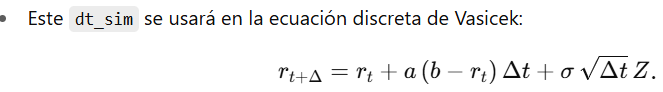

9. Simular tasas Vasicek:

   -Recorremos cada moneda m en monedas_unicas. Para cada una obtenemos sus parámetros a, b, sigma ya calibrados. r0 = tasas_iniciales[m] es la tasa corta a 𝑡 = 0.
   
   -idx = indice_moneda[m] es la posición del choque de esa moneda en nuestro vector correlacionado de dimensión num_vars.

   -Bucle por simulación (sim = 0 … num_simulaciones-1):
      -Inicialmente, simulaciones_tasas[m][sim,0] = r0.
      -Luego, para cada paso temporal t = 1 … num_pasos:
      -r_prev = simulaciones_tasas[m][sim,t-1] es la tasa del paso anterior.
      -Z = shocks_correlacionados[sim, t-1, idx] saca el choque correlacionado correspondiente a la variable “d<m>” en la simulación sim y paso t-1.
   
   -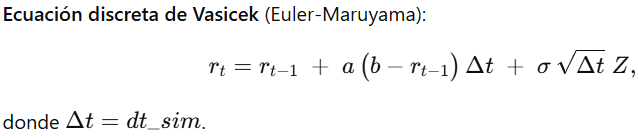

   -Se guarda el resultado en simulaciones_tasas[m][sim, t].

10. Diagnóstico de una trayectoria (simulación 0, primeros pasos):
   
   -Finalmente, se imprime para cada moneda la primera simulación (sim=0) y los primeros 5 pasos (t=0..4). Esto es solo un chequeo rápido para asegurarse de que las tasas estén variando de forma razonable.
   
   -Debe verse algo como [r0, r1, r2, r3, r4], con cada valor positivo y cercano al nivel inicial más o menos desplazado según a, b, sigma y el choque Z.

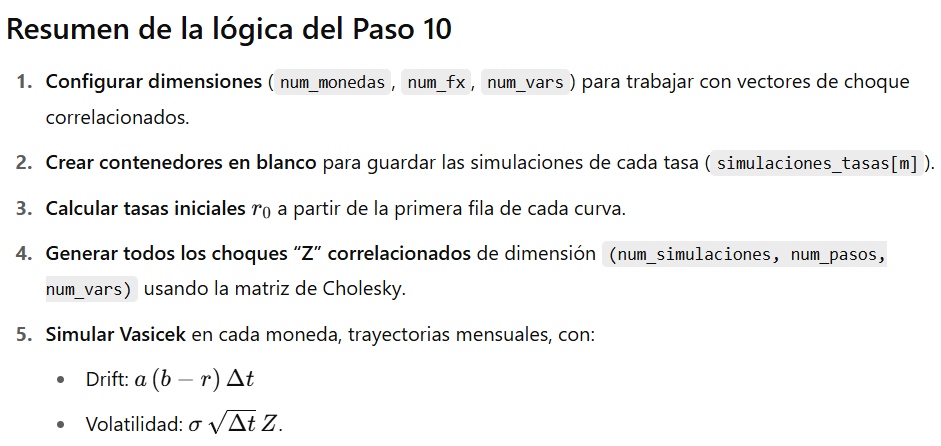



In [ ]:
# Paso 11 – Curvas re-ancladas con desplazamiento paralelo

# ❶ En lugar de almacenar DataFrames para cada simulación y paso,
#     usamos un array NumPy 3D para los factores de descuento:
#     dims = (num_simulaciones, num_pasos+1, num_tenores)
dfs_array = {
    m: np.zeros((num_simulaciones, num_pasos + 1, len(curvas_descuento[m]['Days'])))
    for m in monedas_unicas
}

# ❷ Extraer los arrays “Days” y la curva inicial en decimales para cada moneda
dias_por_moneda = {}
curva0_por_moneda = {}
r_short0_por_moneda = {}
for m in monedas_unicas:
    dias = curvas_descuento[m]['Days'].values              # array de tenores
    curva0 = curvas_descuento[m]['Zero Rate'].values / 100  # en fracción
    dias_por_moneda[m] = dias
    curva0_por_moneda[m] = curva0
    r_short0_por_moneda[m] = curva0[0]                      # tenor 1 día

# ❸ Simular desplazamientos paralelos paso a paso
for m in monedas_unicas:
    dias = dias_por_moneda[m]
    curva0 = curva0_por_moneda[m]
    r_short0 = r_short0_por_moneda[m]

    for sim in range(num_simulaciones):
        for t in range(num_pasos + 1):
            if t == 0:
                r_curve = curva0.copy()  # sin desplazamiento
            else:
                # ❹ Toma la tasa corta simulada para este sim y t
                r_short_sim = simulaciones_tasas[m][sim, t]
                delta = r_short_sim - r_short0
                r_curve = curva0 + delta  # curva desplazada en paralelo

            # ❺ Calcula el factor de descuento para todos los tenores de una vez
            df = np.exp(-r_curve * dias / 365)

            # ❻ Guardar en el array NumPy
            dfs_array[m][sim, t, :] = df

            # ❼ Diagnóstico opcional para la moneda de valoración, simulación 0
            if sim == 0 and t in (0, 1) and m == moneda_valoracion:
                print(f"\n{m} | paso {t}")
                print("  r_short_sim =", r_curve[0])
                print("  DF[tenor=1d] =", df[0])

1. Estructura:

   -Se requiere guardar, para cada moneda m, todos los factores de descuento simulados, no solo el “short rate”.
   
   -Cada curva de descuento tiene un número fijo de “tenores” (p. ej. 1,10,30,90,180,365,… días).
   
   -Al final necesitamos, para cada simulación y cada paso de tiempo 𝑡, un factor de descuento DF(t, Days i) para cada tenor Days_i.

   -Dimensiones de dfs_array[m]
   
   -num_simulaciones: número de trayectorias Montecarlo (por ejemplo, 1.000).
   
   -num_pasos + 1: pasos de tiempo incluye 𝑡 = 0 (inicio) y 𝑡 = 1,2,…,num_pasos.
   
   -len(curvas_descuento[m]['Days']): cantidad de tenores en la curva de la moneda m. En conjunto, dfs_array[m] tiene forma (num_simulaciones, num_pasos+1, n_tenores).

2. Extraer los arrays “Days” y la curva inicial en decimales para cada moneda:

   -dias_por_moneda[m] Gguarda el arreglo de “Days” (tenores en días) de la curva inicial para la moneda m. Ejemplo: para CLP podría ser [1, 7, 30, 90, 180, 365, 730].

   -curva0_por_moneda[m] toma la columna 'Zero Rate' de la curva de la hoja Excel, divide por 100 para pasar de porcentaje a decimal. Resultado: un arreglo curva0 de la forma [r_1d, r_7d, r_30d, …] en decimales.

   -r_short0_por_moneda[m] extrae curva0[0], que es la tasa “corta” de la curva inicial (por convención, el primer tenor suele ser 1 día o overnight). Ese r_short0 será el punto de partida (anclaje) para calcular el “parallel shift” en cada simulación.

   -Todo esto se hace porque que dias_por_moneda que se usa para calcular el factor de descuento: DF = exp(−𝑟 × days/365)
   
   -curva0_por_moneda es la curva original, sin simulación, a la que le sumaremos un desplazamiento paralelo.
   
   -r_short0_por_moneda es la tasa inicial (a “1 día”), que usamos para medir cuánto se ha movido la tasa corta simulada respecto a la original.

3. Simular desplazamientos paralelos paso a paso:

   -Bucle externo: for m in monedas_unicas, se repite para cada moneda m la construcción de la curva simulada.
   
   -Bucle intermedio: for sim in range(num_simulaciones), se usa para cada trayectoria Montecarlo (índice sim), simula la curva a través de los pasos de tiempo.
   
   -Bucle interno: for t in range(num_pasos + 1): Para cada paso de tiempo 𝑡 — desde 𝑡 = 0 hasta 𝑡 = num_pasos— se calcula la curva re-anclada.

   -Para el caso t = 0 no hay simulación: la curva simulada es exactamente la curva inicial (curva0), sin ningún shift.

   -Para t > 0 r_short_sim es la tasa corta simulada para la moneda m, en la simulación sim y paso t.
      -delta = r_short_sim - r_short0 es el desplazamiento respecto a la tasa inicial corta.
      -Para simular un desplazamiento paralelo, sumamos delta a toda la curva inicial:
      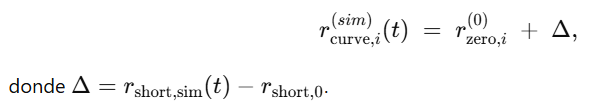
      -Así se obtiene r_curve como un arreglo de la misma longitud que curva0, solo que “levanta” o “baja” toda la curva inicial en la misma cantidad delta.
   
   -r_curve es el arreglo de tasas en decimales para cada tenor (en fracción anual). 
   
   -dias es un arreglo paralelo que contiene el número de días para cada componente (por ejemplo [1, 10, 30, …]).Entonces el factor de descuento para cada tenor Days𝑖 es:

   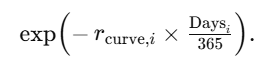

   -Esto produce un arreglo df de la misma longitud que dias y r_curve, con los DF𝑖 correspondientes.

   -Por último se asigna el arreglo de factores de descuento df a la posición (sim, t, :) dentro del array 3D de la moneda m. De este modo, dfs_array[m] se va llenando con todos los factores de descuento de cada simulación y cada paso a cada tenor.

4. Diagnóstico opcional para la moneda de valoración:

   -Solo para la simulación 0 (trayectoria “de ejemplo”) y para 𝑡 = 0, 1 y únicamente en la moneda base (m == moneda_valoracion):
   
   -Imprime el r_short_sim (tasa corta) y el factor de descuento a “1 día” (df[0]).
   
   -Esto sirve para comprobar que el parallel shift se está haciendo correctamente: en 𝑡 = 0, r_curve[0] debería ser exactamente la tasa inicial corta y DF[tenor=1d] = exp(−𝑟short,0/365). En 𝑡=1, vemos cómo cambió la tasa corta y el DF asociado.

-En resumen: 

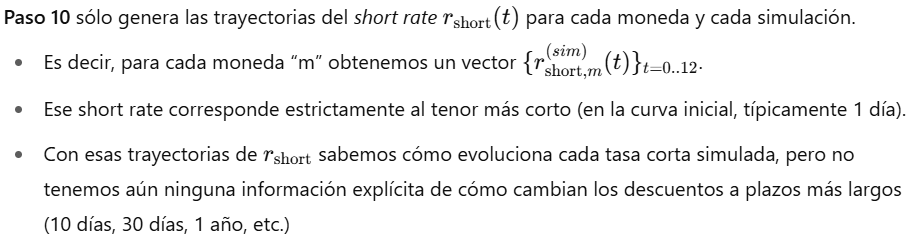

------------------------------------------------------------------------------------------------------------------------------------------------

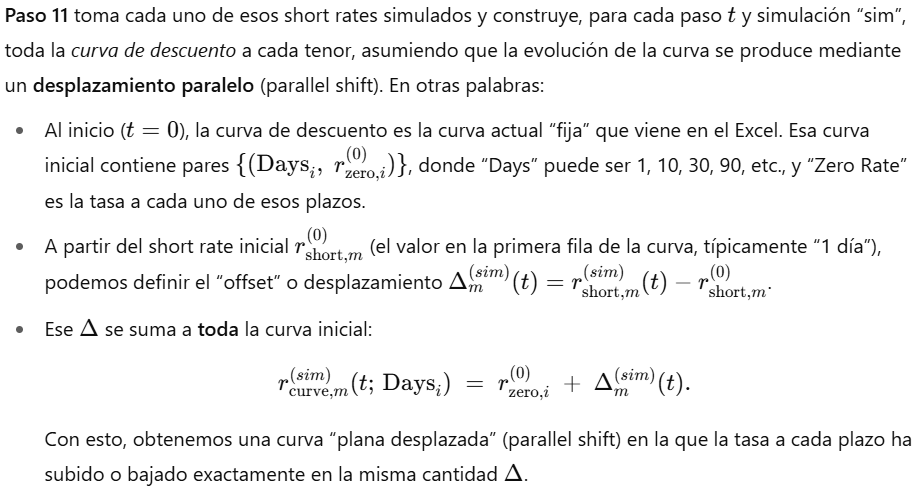

------------------------------------------------------------------------------------------------------------------------------------------------

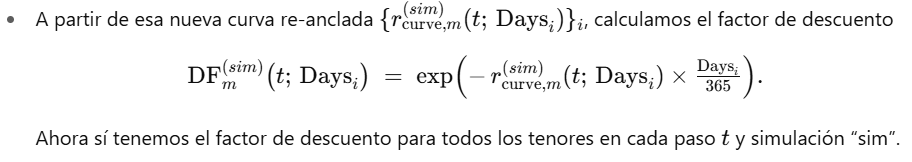

In [ ]:
# Paso 12 · Simulación de tipos de cambio (TC) con paridad de tasas + shocks

# ❶ Crear diccionario para guardar simulaciones de FX
simulaciones_tc = {m: np.zeros((num_simulaciones, num_pasos + 1)) for m in monedas_relacionadas}

# ❷ Definir días por paso (aprox. un mes)
step_days = 365.0 / num_pasos  # ≈ 30.4167 si num_pasos = 12

# ❸ Hallar índice de cada FX en el vector de shocks (mismo orden que nombres_vars)
idx_fx = {
    m: nombres_vars.index(f"logRet_{m}{moneda_valoracion}")
    for m in monedas_relacionadas
}

# ❹ Para cada moneda FX, obtenemos el precio inicial y llenamos t=0
for m in monedas_relacionadas:
    S0 = datos_fx[m].iloc[-1]  # último precio histórico
    simulaciones_tc[m][:, 0] = S0

# ❺ Recorrer simulaciones y pasos para actualizar el TC
for m in monedas_relacionadas:
    idx = idx_fx[m]

    for sim in range(num_simulaciones):
        for t in range(1, num_pasos + 1):
            # — tasas cortas simuladas (decimales) en t-1 y t —
            r_ext_t1 = simulaciones_tasas[m][sim, t - 1]
            r_ext_t  = simulaciones_tasas[m][sim, t]
            r_loc_t1 = simulaciones_tasas[moneda_valoracion][sim, t - 1]
            r_loc_t  = simulaciones_tasas[moneda_valoracion][sim, t]

            # — factores de descuento para el intervalo [t-1 → t] —
            DF_ext_t1 = np.exp(-r_ext_t1 * step_days / 365.0)
            DF_ext_t  = np.exp(-r_ext_t  * step_days / 365.0)
            DF_loc_t1 = np.exp(-r_loc_t1 * step_days / 365.0)
            DF_loc_t  = np.exp(-r_loc_t  * step_days / 365.0)

            # — drift de paridad de tasas: ratio de descuentos —
            ratio_desc = (DF_ext_t / DF_ext_t1) / (DF_loc_t / DF_loc_t1)

            # — choque aleatorio correlacionado de FX —
            Z = shocks_correlacionados[sim, t - 1, idx]
            # ❻ Usar dt_sim en lugar de dt genérico
            diff = np.sqrt(dt_sim) * Z

            # — actualización del tipo de cambio —
            S_prev = simulaciones_tc[m][sim, t - 1]
            S_t = S_prev * ratio_desc * np.exp(diff)
            simulaciones_tc[m][sim, t] = S_t

# ❼ Diagnóstico breve de la primera simulación
print("\nChequeo de simulaciones de FX (simulación 0, primeros pasos):")
for m in monedas_relacionadas:
    print(f"{m}/{moneda_valoracion}: {simulaciones_tc[m][0, :5]}")

1. Crear diccionario para guardar simulaciones de FX:

   -Crea un diccionario simulaciones_tc con clave cada moneda distinta de la de valoración (monedas_relacionadas). El valor para cada clave es un array NumPy de ceros con forma (num_simulaciones, num_pasos+1). En ese array se guardará , para cada simulación (fila) y cada paso t = 0, ..., num_pasos, el valor del tipo de cambio simulado en el paso t.

2. Definir días por paso:

   -Calcula cuántos días (en promedio) hay en cada paso, partiendo del horizonte de 1 año dividido en num_pasos.

3. Hallar índice de cada FX en el vector de shocks (mismo orden que nombres_vars):

   -Construye un diccionario idx_fx cuyo valor para cada moneda “m” es el índice (posición) en la última dimensión del array de shocks correlacionados.
   
   -Durante el Paso 9, se contcatenaron las Series de “Δtasas” y “log-retornos FX” en un DataFrame con columnas nombradas exactamente como "d<moneda>" o "logRet_<moneda><moneda_valoracion>".
   
   -La lista nombres_vars contiene esas etiquetas en el mismo orden usado para armar la matriz de Cholesky. Aquí se busca la posición exacta del elemento "logRet_{m}{moneda_valoracion}" dentro de nombres_vars.

   -Esto es necesario porque al simular Fx, en cada paso se necesitarán extraer el choque correspondiente al log‐retorno de “m vs moneda_valoracion” que ya se generó en shocks_correlacionados.

   -Si idx_fx["USD"] = 2, entonces en shocks_correlacionados[sim, t, 2] estará el valor 𝑍 (normal correlacionado) que corresponde a log(𝑆𝑡/𝑆𝑡−1) para USD/CLP.

4. Para cada moneda FX, obtenemos el precio inicial y llenamos t=0

   -Para cada moneda “m” (por ejemplo, "USD" si valoramos en CLP), toma S0 = datos_fx[m].iloc[-1], que es el último precio real disponible de USD/CLP.
   
   -Rellena toda la columna 𝑡 = 0 en simulaciones_tc[m] con ese valor S0. Es decir, inicia todas las simulaciones en el precio real actual en el instante 𝑡 = 0.

5. Recorrer simulaciones y pasos para actualizar el TC:

   -Para cada m en monedas_relacionadas (ej. "USD", "EUR", etc.), se obitene su índice idx = idx_fx[m] en el vector de shocks correlacionados.Luego, dentro de ese bucle, se recorre cada simulación sim y cada paso t = 1..num_pasos.

   -r_ext_t1 = simulaciones_tasas[m][sim, t - 1]: la tasa corta de la moneda extranjera (USD, EUR, etc.) en el paso 𝑡−1, simulación sim.
   
   -r_ext_t = simulaciones_tasas[m][sim, t]: la misma tasa corta pero en el paso 𝑡.
   
   -r_loc_t1 = simulaciones_tasas[moneda_valoracion][sim, t - 1]: la tasa corta de la moneda local (por ejemplo, CLP) en 𝑡−1.
   
   -r_loc_t = simulaciones_tasas[moneda_valoracion][sim, t]: la tasa corta local en 𝑡.

   -Luego, se calculan los factores de descuento para el intervalo [t-1 --> t]

   -A partir de lo anterior es necesario calcular el drift según la paridad de tasas: 

   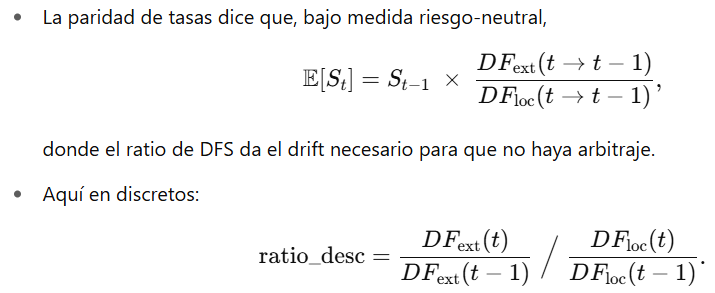

   -Con ese ratio_desc, multiplicamos el precio anterior S_prev para imponer el drift sin choque.

   -Z = shocks_correlacionados[sim, t - 1, idx] es el componente aleatorio (normal correlacionado) que corresponde exactamente a la variable logRet𝑚/moneda_valor.
   
   -Para incluirlo en la dinámica se hace diff = np.sqrt(dt_sim) * Z.
   
   -Generalmente en Vasicek o en un GBM clásico el término estocástico es 𝜎sqr(Δ𝑡)𝑍. Pero aquí, como ya se tiene 𝜎 “incorporado” en el tamaño del shock correlacionado, por lo tanto se usa solo sqr(Δt).

   -Se multiplica el precio del paso anterior S_prev por: El drift de paridad de tasas: ratio_desc y El choque aleatorio log-normal: exp(sqr(Δ𝑡)𝑍).

   -simulaciones_tc[m][sim, t] = S_t, escribe el valor simulado S_t en la matriz simulaciones_tc[m].

5. Diagnóstico breve de la primera simulación:

   -Imprime, para la simulación 0 (fila índice 0) y los primeros 5 pasos (𝑡 = 0..4), los valores de 𝑆𝑡 que se acaban de generar.
   
   -Sirve como chequeo rápido para verificar que las trayectorias no muestren saltos irreales o valores negativos (en general el FX no debería ser negativo).

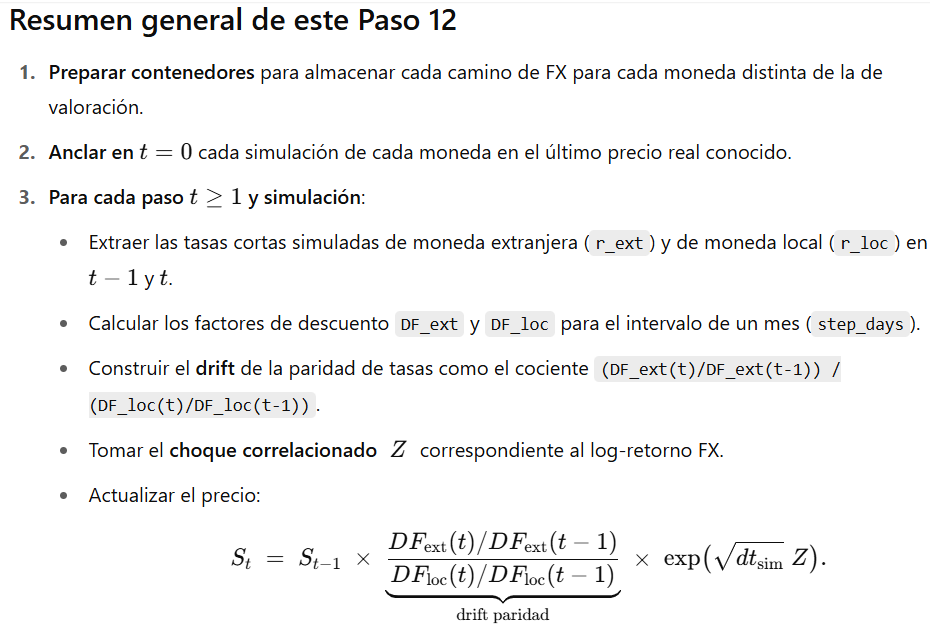
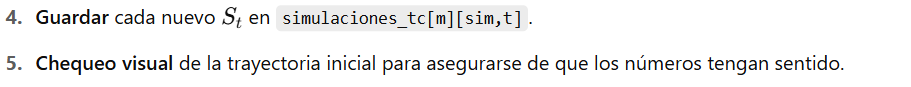

In [ ]:
# Paso 13: Valorar Forwards (con fecha de valoración solicitada)

# ❶ Preguntar al usuario la fecha de valoración
fecha_str = input("Ingresa la fecha de valoración (YYYY-MM-DD o DD-MM-YYYY): ").strip()
try:
    fecha_valoracion = pd.to_datetime(fecha_str, format="%Y-%m-%d", errors="raise")
except:
    try:
        fecha_valoracion = pd.to_datetime(fecha_str, format="%d-%m-%Y", errors="raise")
    except:
        raise ValueError(f"Formato de fecha inválido: '{fecha_str}'. Debe ser YYYY-MM-DD o DD-MM-YYYY.")


# ❷ Inicializar la estructura de valores simulados para cada forward
valores_forward = {
    fid: np.zeros((num_simulaciones, num_pasos + 1))
    for fid in forwards_df['ID']
}

# ❸ Precomputar step_days (igual que en Paso 12)
step_days = 365.0 / num_pasos

# ❹ Para cada forward, guardar su información básica y precomputar índices de tenor
info_forwards = []
for _, row in forwards_df.iterrows():
    fid = row['ID']
    moneda = row['Moneda']
    sentido = 1 if row['Sentido'].upper() == 'BUY' else -1
    strike = float(row['Strike'])
    nocional = float(row['Nocional'])
    fin = row['Fin']

    # Calcular días hasta vencimiento respecto a fecha de valoración
    dias_vencimiento = (fin - fecha_valoracion).days

    # Extraer vector de tenores para esta moneda
    dias = dias_por_moneda[moneda]  # array de "Days" de la curva original

    # Precomputar índice de tenor para cada paso t
    idx_tenor_por_paso = []
    for t in range(num_pasos + 1):
        dias_desde_t = dias_vencimiento - int(t * step_days)
        if dias_desde_t <= 0:
            idx_tenor_por_paso.append(None)
        else:
            idx = np.abs(dias - dias_desde_t).argmin()
            idx_tenor_por_paso.append(idx)

    info_forwards.append({
        'fid': fid,
        'moneda': moneda,
        'sentido': sentido,
        'strike': strike,
        'nocional': nocional,
        'idx_tenor_por_paso': idx_tenor_por_paso
    })

# ❺ Recorrer cada forward y simular su valoración
for info in info_forwards:
    fid = info['fid']
    moneda = info['moneda']
    sentido = info['sentido']
    strike = info['strike']
    nocional = info['nocional']
    idx_tenor_por_paso = info['idx_tenor_por_paso']

    for sim in range(num_simulaciones):
        for t in range(num_pasos + 1):
            idx_tenor = idx_tenor_por_paso[t]
            if idx_tenor is None:
                # El forward ha vencido, valor = 0
                valor = 0.0
            else:
                # Extraer factor de descuento desde dfs_array
                df = dfs_array[moneda][sim, t, idx_tenor]

                # Determinar precio spot en t
                if moneda == moneda_valoracion:
                    S_T = 1.0
                else:
                    S_T = simulaciones_tc[moneda][sim, t]

                # Payoff descontado
                valor = nocional * (S_T - strike) * sentido * df

            valores_forward[fid][sim, t] = valor

# ❻ Construir DataFrame con el valor promedio por paso para cada forward
valores_forward_df = pd.DataFrame({
    fid: valores_forward[fid].mean(axis=0)
    for fid in valores_forward
})
valores_forward_df.index.name = "Paso"

print("Número de pasos calculados:", valores_forward_df.shape[0])
display(valores_forward_df.head())


1. Preguntar al usuario la fecha de valoración:

   -El código pregunta por la fecha de valoración, es importante que los inputs utilizados en un principio sean acordes a esta fecha, es decir, si valoramos al 31.12.2024, que las curvas USD, CLP sean con fecha 31.12.2024 y que las tasas y tc históricos lleguen hasta el 31.12.2024.

2. Inicializar la estructura de valores simulados para cada forward:

   -Recorre cada fid (ID de forward) presente en forwards_df['ID'].
   
   -Para cada ID crea un array NumPy de ceros con forma (num_simulaciones, num_pasos+1).
   
   -Cada fila de ese array corresponderá a una simulación Montecarlo, y cada columna a un paso de tiempo 𝑡 = 0, 1, …,num_pasos.
   
   -Más adelante, en el bucle, se iran llenando valores_forward[fid][sim, t] con el valor descontado del forward en la simulación sim y paso t.

3. Precomputar step_days (igual que en Paso 12):

   -Se calcula nuevamente como “días por paso” para un horizonte de un año dividido en num_pasos.

4. Para cada forward, guardar su información básica y precomputar índices de tenor:

   -for _, row in forwards_df.iterrows(): recorre cada fila (each forward). Se extraen:

      -fid: identificador único del forward.
      -moneda: la moneda en que está denominado el forward (p. ej. "USD").
      -sentido: si row['Sentido'].upper() es "BUY" guardamos 1; si es "SELL", guardamos -1. Esto servirá para aplicar el signo en el payoff
      -strike: precio forward pactado (float).
      -nocional: monto nocional del forward (float).
      -fin: fecha de vencimiento (datetime) del contrato de forward.

   -Luego, se resta la fecha de vencimiento (fin) menos la fecha_valoracion que el usuario ingresó.

   -dias_por_moneda fue construido en el Paso 11. Es un array NumPy con todos los plazos (en días) de la curva original de esa moneda. Ejemplo: array([1, 10, 30, 90, 180, 365, 730]).

   -Se crea una lista vacía idx_tenor_por_paso = []. Luego, para cada paso t = 0..num_pasos: dias_desde_t = dias_vencimiento - int(t * step_days), donde:

      -t * step_days es cuántos días han transcurrido en la simulación desde la fecha de valoración.
      -dias_desde_t es el número aproximado de días que restan hasta vencimiento en el paso t.
      -Si dias_desde_t <= 0, significa que para ese paso t ya pasó la fecha de vencimiento → guardamos None, porque valoramos el forward en cero cuando ya ha vencido.
      -Si dias_desde_t > 0, buscamos el tenor de la curva “más cercano” a dias_desde_t:

   -idx = np.abs(dias - dias_desde_t).argmin(), devuelve el índice en el array dias cuyo valor está más próximo a dias_desde_t. Y se agrega ese idx a la lista idx_tenor_por_paso.

   -Al final de la iteración, se crea un diccionario con: 'fid', 'moneda', 'sentido', 'strike', 'nocional'.
   
   -'idx_tenor_por_paso': la lista de índices precomputados (o None) de longitud num_pasos+1. A esa lista info_forwards se iran acumulando un diccionario por cada forward.

5. Recorrer cada forward y simular su valoración:

   -for info in info_forwards: extrae el diccionario con toda la info básica de ese forward.

   -Para cada simulación sim y cada paso t se saca el índice de tenor precomputado idx_tenor = idx_tenor_por_paso[t]. Si idx_tenor es None, significa que en el paso t ya excedimos o alcanzamos la fecha de vencimiento del forward --> su valor en 𝑡 es 0.

   -Si el forward ya venció directamente se asigna 0 y se guarda. No hay payoff ni factor de descuento que aplicar.

   -Si el forward aun no vence, se busca en dfs_array[moneda], que es el array 3D de factores de descuento simulados para esa moneda, la posición [sim, t, idx_tenor]. Eso da el factor de descuento DF(𝑡,Dayscercano) apropiado para el plazo que queda hasta vencimiento (o el más cercano en la curva).

   -Si el forward está denominado en la misma moneda que la de valoración, su precio spot en esa moneda es 1.0. Si no, se toma el tipo de cambio simulado simulaciones_tc[moneda][sim, t] que ya fue calculado en el Paso 12.

   -Para calcular el payoff descontado se aplica lo siguiente: 
   
   -El payoff de un forward “vanilla” es nocional × (𝑆𝑇 − strike). Si sentido = 1 (BUY), el payoff es nocional × (𝑆𝑇 − strike). Si sentido = -1 (SELL), el payoff es nocional × (strike − 𝑆𝑇). Finalmente, se descuenta: ×𝑑𝑓. En un contrato de forward, normalmente se asume que no hay intercambio de cash flows intermedios y que todo se liquida a vencimiento, pero aquí descontamos “hasta hoy y luego tomamos promedio en t=0” para el cálculo de CVA. Sean 𝑆𝑇 y strike ambos en la misma moneda de valoración (porque ya ajustamos el FX), por tanto el resultado está en moneda de valoración.

   -Luego se guardan los valores correspondientes en el array.

6. Construir DataFrame con el valor promedio por paso para cada forward

   -Para cada fid en valores_forward, valores_forward[fid] es un array (num_simulaciones, num_pasos+1).
   
   -La expresión valores_forward[fid].mean(axis=0) calcula la media en la dimensión de simulaciones, es decir, genera un arreglo de largo num_pasos+1 con E[valor(𝑡)] para cada paso 𝑡.
   
   -El diccionario que pasamos a pd.DataFrame(...) tiene clave fid y valor esa serie de medias; el DataFrame resultante tiene tantas columnas como forwards (cada columna una ID), y tantas filas como pasos.

   -valores_forward_df.index.name = "Paso" nombra al índice  DataFrame se llama “Paso”, indicando que la fila 0 corresponde a 𝑡 = 0, fila 1 a 𝑡 = 1, etc.
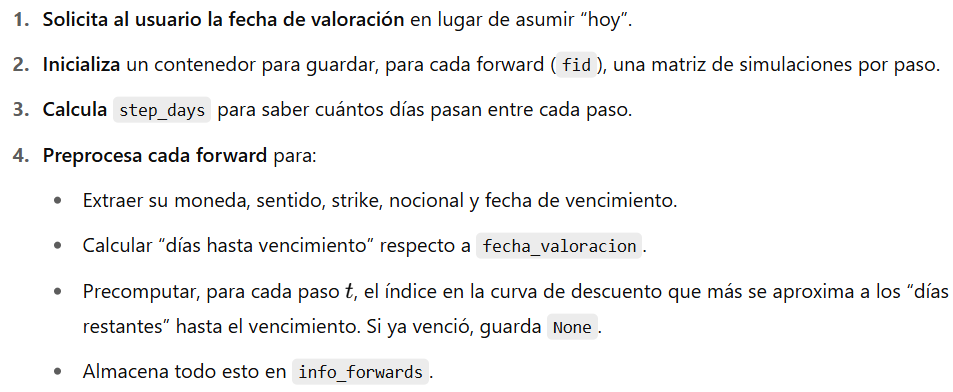
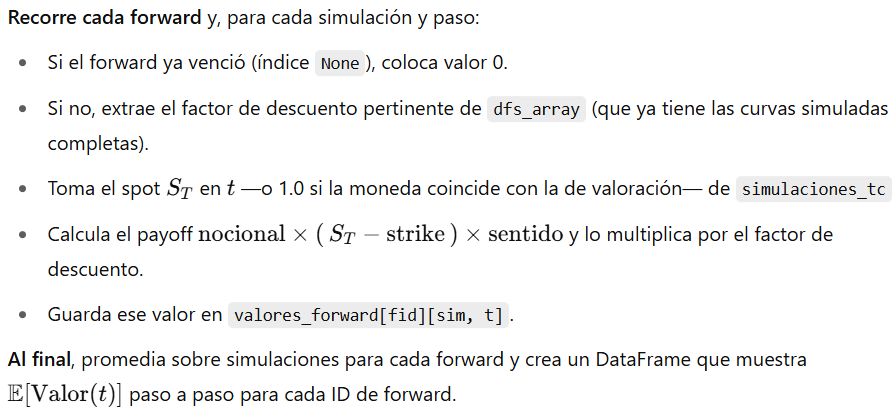

7. Metodología de valoración FWDS:

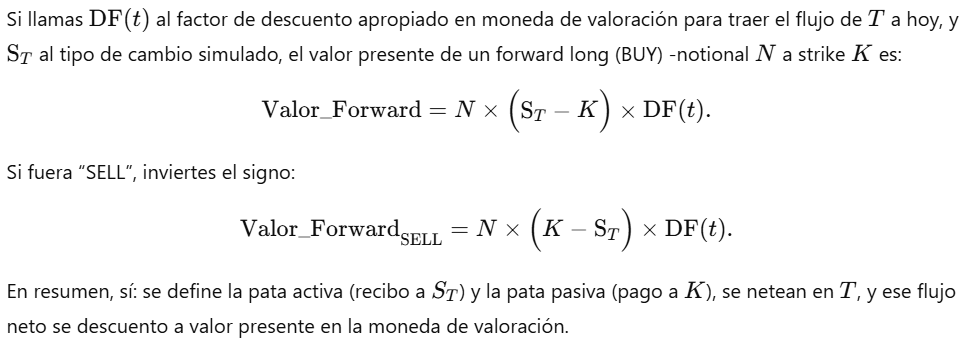


In [ ]:
# Paso 14 mejorado: Calcular Exposición Esperada (EE) de forma vectorizada

# ❶ Validación de dimensiones de valores_forward
for fid, mat in valores_forward.items():
    if mat.shape != (num_simulaciones, num_pasos + 1):
        raise ValueError(f"Dimensiones incorrectas en forward {fid}: {mat.shape}")

# ❷ Obtener lista ordenada de forward IDs
fids = list(valores_forward.keys())

# ❸ Apilar todos los valores en un único array 3D: (num_forwards, num_simulaciones, num_pasos+1)
stack = np.stack([valores_forward[fid] for fid in fids], axis=0)

# ❹ Calcular Exposición Esperada por forward y paso:
#     - max(stack, 0) para eliminar valores negativos
#     - luego promediar sobre simulaciones (axis=1)
ee_array = np.maximum(stack, 0).mean(axis=1)  # shape = (num_forwards, num_pasos+1)

# ❺ Calcular EE_Total (suma de todos los forwards en cada paso)
ee_total = ee_array.sum(axis=0)  # shape = (num_pasos+1,)

# ❻ Construir índice de tiempos en años
tiempos = np.linspace(0, horizonte_anios, num_pasos + 1)
# Crear DataFrame con columnas para cada forward
ee_forward = pd.DataFrame(data=ee_array.T, index=tiempos, columns=fids)
ee_forward.index.name = "Tiempo (años)"
# Agregar columna EE_Total
ee_forward['EE_Total'] = ee_total

# ❼ Mostrar solo los primeros 5 pasos y las primeras 5 columnas
print("\n📊 Exposición Esperada (primeros 5 pasos y primeras 5 columnas):")
display(ee_forward.iloc[:5, :min(5, len(ee_forward.columns))])

# ❽ Mostrar resumen de EE_Total
print("\nEE_Total (primeros 5 pasos):")
display(ee_forward['EE_Total'].iloc[:5])

1. Validación de dimensiones de valores_forward:

   -Recorre cada par (fid, mat) en el diccionario valores_forward, donde fid es el ID del forward y mat es el array NumPy de forma (num_simulaciones, num_pasos+1) que contiene sus simulaciones de valor por paso.
   
   -Comprueba que mat.shape sea exactamente (num_simulaciones, num_pasos+1).
   
   -Si alguna matriz no cumple esa forma, lanza un error indicando qué forward tiene dimensiones incorrectas.

2. Obtener lista ordenada de forward IDs:

   -Toma las claves (IDs) del diccionario valores_forward y las convierte en una lista ordenada fids.

3. Apilar todos los valores en un único array 3D: (num_forwards, num_simulaciones, num_pasos+1):

   -Genera una lista de arrays [valores_forward[fid] for fid in fids]. Cada uno tiene forma (num_simulaciones, num_pasos+1).
   
   -Llama a np.stack(..., axis=0) para concatenar esos arrays a lo largo de un nuevo eje en la posición 0.
   
   -El resultado, stack, tiene forma (num_forwards, num_simulaciones, num_pasos+1), donde num_forwards = len(fids).

   -stack[i] es la matriz (num_simulaciones, num_pasos+1) para el forward número i (según el orden en fids).
   
   -stack[i, sim, t] es el valor del forward fids[i] en la simulación sim y paso t.

4. Calcular Exposición Esperada por forward y paso:

   -Para cada elemento de stack[i, sim, t], reemplaza valores negativos por 0 y deja los positivos igual.
   
   -Esto implementa max(valor, 0), porque en la Exposición Esperada solo consideramos la parte positiva (la contraparte no puede deberte más de cero en exposición).

   -Después de aplicar np.maximum, se tiene un array de forma (num_forwards, num_simulaciones, num_pasos+1) con solo valores ≥ 0.
   mean(axis=1) promedia a lo largo del eje “simulaciones”, es decir, calcula: 
      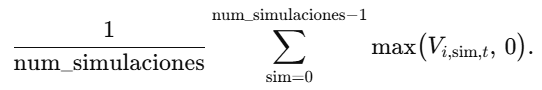

   -El resultado, ee_array, tiene forma (num_forwards, num_pasos+1). Cada fila es un forward, cada columna un paso.

   -ee_array[i, t] es la Exposición Esperada en el paso t para el forward fids[i].

5. Calcular EE_Total (suma de todos los forwards en cada paso)

   -.sum(axis=0) toma ee_array, que es (num_forwards, num_pasos+1), y suma a lo largo del eje de “forwards” (fila). El resultado, ee_total, es un vector de longitud num_pasos+1, donde cada componente: 
      -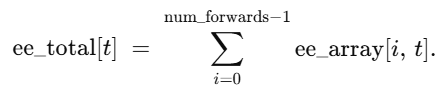

   -En otras palabras, la exposición global del portafolio en cada paso.

6. Construir índice de tiempos en años:

   -Genera un arreglo de tamaño num_pasos+1 que va desde 0 hasta horizonte_anios (p.ej. 1.0 año), equiespaciado.

   -Para construir el DataFrame de los Forwards, se toma ee_array que tenía forma (num_forwards, num_pasos+1). Luego, se toma su transpuesta ee_array.T, que es (num_pasos+1, num_forwards). Ahora cada fila corresponde a un paso de tiempo y cada columna a un forward.
   
   -Al pasar index=tiempos hace que esa fila 0 corresponda a tiempos[0] = 0.0 años, la fila 1 a 1/12 años, etc.
   
   -Con columns=fids etiquetamos cada columna con el ID de cada forward (en el mismo orden que se había apilado anteriormente).
   
   -ee_forward.index.name = "Tiempo (años)", le da nombre “Tiempo (años)” al índice, para que quede claro en la salida que la fila 0 es “0 años (inmediato)”, etc.
   
   -ee_total es un vector de largo num_pasos+1. Al asignarlo a ee_forward['EE_Total'], se agrega al DataFrame como una columna más, con ese mismo índice de tiempos. Ahora ee_forward tiene num_forwards + 1 columnas: una por cada forward, más la columna agregada EE_Total.

7. Mostrar solo los primeros 5 pasos y las primeras 5 columnas:

   -ee_forward.iloc[:5, :min(5, len(ee_forward.columns))] selecciona las primeras 5 filas (pasos 0 a 4) y las primeras 5 columnas (o menos si hay menos de 5 columnas). Esto sirve para comprobar rápidamente los valores de exposición de los primeros tipos de forward sin inundar la pantalla.

8. Mostrar resumen de EE_Total:

   -ee_forward['EE_Total'].iloc[:5] extrae las primeras 5 filas de la columna EE_Total. Imprime esos cinco valores para ver cómo evoluciona la exposición agregada al inicio.

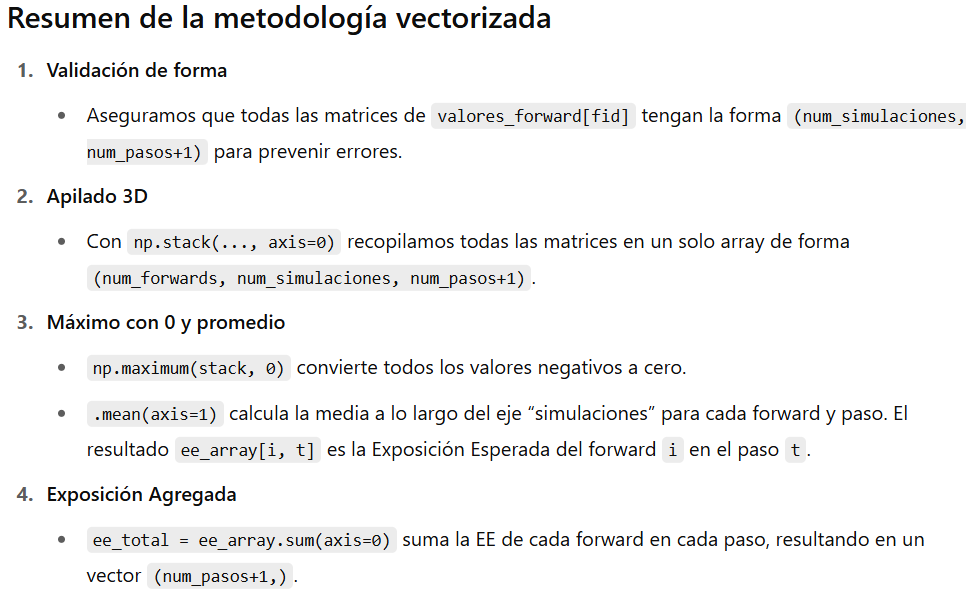
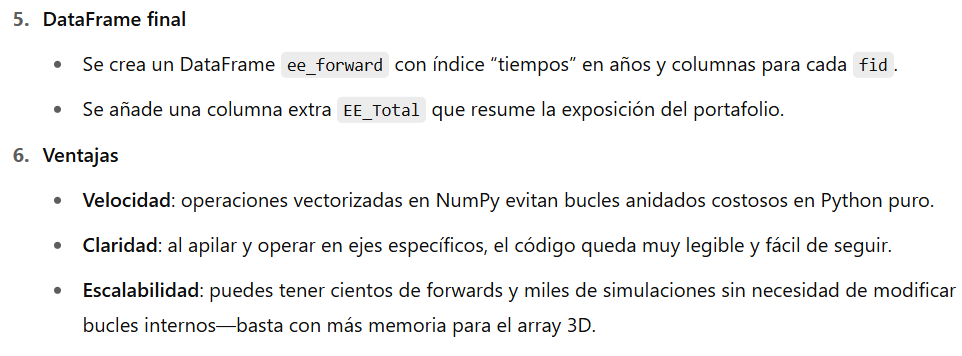

In [ ]:
# Paso 15: Calcular el CVA por forward usando λ = (1 – e^{-spread})/(1 – R)
#           y PD_acum(t) = 1 – e^{-λ t}

cva_forward = {}

# ❶ Definir step_days (mismo que en Paso 12 y 13)
step_days = 365.0 / num_pasos

# ❷ Construir vector de índices de tenor para la moneda de valoración
#     Basado en t*step_days, con t = 0..num_pasos
dias_val = dias_por_moneda[moneda_valoracion]  # array de "Days" de la curva de valoración
idx_tenor_val_t = []
for t in range(num_pasos + 1):
    tenor_req = int(t * step_days)
    idx = np.abs(dias_val - tenor_req).argmin()
    idx_tenor_val_t.append(idx)

# ❸ Precomputar DF promedio por paso t para la moneda de valoración
df_promedio_por_t = np.zeros(num_pasos + 1)
for t in range(num_pasos + 1):
    idx_tenor = idx_tenor_val_t[t]
    # Extraer DF(t) de todas las simulaciones y promediar
    dfs_t = dfs_array[moneda_valoracion][:, t, idx_tenor]
    df_promedio_por_t[t] = dfs_t.mean()

# ❹ Grid de tiempos en años
tiempos = np.linspace(0, horizonte_anios, num_pasos + 1)

for _, row in forwards_df.iterrows():
    fid = row['ID']
    spread_bps = float(row['CDS_Propio'])     # spread en bps
    recovery = float(row['Recovery'])          # recuperación R (0–1)
    lgd = 1.0 - recovery

    # ❺ Convertir spread a decimal (e.g., 100 bps → 0.01)
    spread_dec = spread_bps / 10000.0

    # ❻ Calcular λ según: λ = (1 – e^{–spread_dec}) / (1 – R)
    if recovery >= 1.0:
        raise ValueError(f"Recovery ≥ 1 para forward {fid}: R = {recovery}")
    lam = (1.0 - np.exp(-spread_dec)) / (1.0 - recovery)

    # ❼ Calcular PD acumulada en cada t: 1 – e^{–λ·tiempos[t]}
    pd_acum = 1.0 - np.exp(-lam * tiempos)

    # ❽ Calcular PD marginal por paso: ΔPD = pd_acum[t] – pd_acum[t-1]
    delta_pd = np.diff(pd_acum, prepend=0.0)

    # ❾ Extraer EE(t) para este forward (asegurar que index de ee_forward coincide con t=0..num_pasos)
    #     Suponemos que ee_forward.index = tiempos en años, en mismo orden que 'tiempos'.
    #     Para mayor seguridad, usamos .iloc por posición:
    ee_t = ee_forward.iloc[:, ee_forward.columns.get_loc(fid)].values
    #    (ó, si ee_forward.index fueran 0..num_pasos, usar ee_forward.loc[t, fid])

    # ❿ Calcular CVA con producto escalar:
    #     CVA = Σ_{t=0}^N [ EE(t) * ΔPD(t) * LGD * DF_promedio_por_t[t] ]
    cva_val = np.dot(ee_t * (delta_pd * lgd), df_promedio_por_t)

    cva_forward[fid] = cva_val

# Convertir a DataFrame
df_cva = pd.DataFrame.from_dict(cva_forward, orient='index', columns=['CVA'])

print("\n💥 CVA por forward:")
display(df_cva)

print(f"\n💰 CVA total del portafolio: {df_cva['CVA'].sum():,.2f}")
print(f"Cantidad de forwards en el archivo: {len(forwards_df)}")
print(f"Forward IDs valorados: {list(cva_forward.keys())}")
print(f"Columnas de exposición esperada: {ee_forward.columns.tolist()}")

1. Definir step_days (mismo que en Paso 12 y 13):

   -Igual que en los pasos anteriores, step_days representa el número aproximado de días que abarca cada paso de tiempo

2. Construir vector de índices de tenor para la moneda de valoración:

   -dias_val = dias_por_moneda[moneda_valoracion], dias_por_moneda se creó en el Paso 11. Para la moneda_valoracion (p. ej. “CLP”), dias_val es un array con todos los tenores (en días) de la curva original.

   -Generar idx_tenor_val_t. Se quiere saber, para cada paso 𝑡 = 0, …, num_pasos, cuál es el índice en dias_val que más se aproxima a “cuántos días han pasado hasta 𝑡” (es decir, t * step_days).
   
   -tenor_req = int(t * step_days) convierte la posición 𝑡 a un número entero de días.
   
   -idx = np.abs(dias_val - tenor_req).argmin() busca el índice en dias_val cuyo valor esté más cerca de ese tenor_req. Al final, idx_tenor_val_t[t] es el índice de la fila en la curva que corresponde a “aprox. 𝑡 meses después” en días.
   
   -Eso permite extraer después el factor de descuento para ese paso: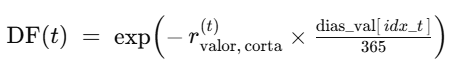

   -Donde  r_{valor,corta}^{(t)} es la tasa corta simulada en esa fecha, pero en este momento solo necesitamos el índice de tenor “cercano” a la cantidad de días que han transcurrido.

3. Precomputar DF promedio por paso t para la moneda de valoración:

   -Para crear un DataFrame promedio por cada paso de tiempo, se realiza lo siguiente:
   
   -Inicialmente, un vector de ceros de longitud num_pasos+1.

   -Para cada paso 𝑡:
      -idx_tenor = idx_tenor_val_t[t] es la posición en la curva que coincide con “días transcurridos hasta 𝑡”.

      -dfs_array[moneda_valoracion][:, t, idx_tenor] extrae, de dfs_array, todos los factores de descuento simulados en la moneda de valoración para la simulación “:” (eje 0), el paso t (eje 1) y el tenor idx_tenor (eje 2).
      
      -Así se obtiene un vector de largo num_simulaciones con {DF(sim)(𝑡)}.
      
      -dfs_t.mean() calcula el promedio de esos factores de descuento sobre todas las simulaciones.
      
      -De esta forma, df_promedio_por_t[t] almacena: 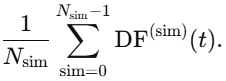

   -Ese “DF promedio” se usará para descontar la Exposición Esperada multiplicada por la probabilidad marginal de default en cada paso.

4. Grid de tiempos en años:

   -tiempos = np.linspace(0, horizonte_anios, num_pasos + 1), crea un arreglo de longitud num_pasos+1 que va desde 0 hasta horizonte_anios (p. ej. 1 año) uniformemente.
   
   -Ejemplo: si horizonte_anios = 1.0 y num_pasos = 12, entonces tiempos = [0, 0.08333…,  0.16667…,…,  1.0].

   -Con for _, row in forwards_df.iterrows(): se toma fila a fila.

   -Para extraer los parámetros de crédito se utiliza lo siguiente: 
     -fid: identificador del forward.
     
     -spread_bps = float(row['CDS_Propio']): el spread del CDS propio, en puntos básicos (bps). Por ejemplo, 100 bps = 1%.
     
     -recovery = float(row['Recovery']): tasa de recuperación 𝑅, en fracción (por ejemplo, 0.40 significa 40% de recuperación).
     
     -lgd = 1.0 - recovery: pérdida dada la recuperación (LGD).

5. Convertir spread a decimal (e.g., 100 bps → 0.01):

   -spread_dec = spread_bps / 10000.0 pasa de bps a fracción.

6. Calcular λ según: λ = (1 – e^{–spread_dec}) / (1 – R):

   -Formula para 𝜆:

   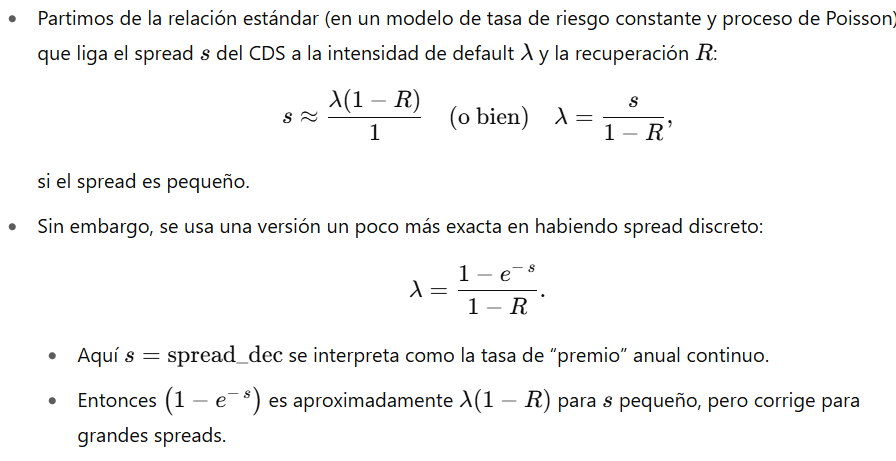

7. Calcular PD acumulada en cada t: 1 – e^{–λ·tiempos[t]}:

   -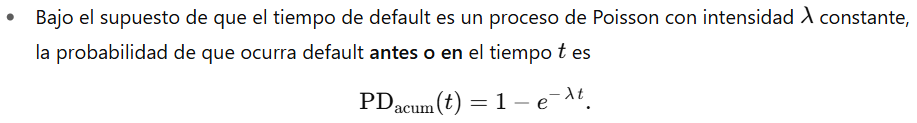

   -Aquí tiempos[t] es el tiempo en años para el paso 𝑡.

8. Calcular PD marginal por paso: ΔPD = pd_acum[t] – pd_acum[t-1]:

   -Probabilidad marginal (condicionada) de default en cada intervalo [𝑡−1,𝑡]:

   -ΔPD(𝑡) = PDacum(𝑡) − PDacum(𝑡−1)

   -Al hacerlo con np.diff(pd_acum, prepend=0.0), se usa usando PDacum(−1) = 0 para que ΔPD(0) = PDacum(0) − 0 = 0.

9. Extraer EE(t) para este forward:

   -ee_forward es un DataFrame cuyas filas están indexadas por “tiempos” (0, 0.0833, …, 1.0) y cuyas columnas incluyen cada fid y, al final, la columna EE_Total.
   
   -Al hacer ee_forward.columns.get_loc(fid) encontramos la posición entera de la columna con nombre igual a fid.
   
   -ee_forward.iloc[:, posición] extrae todas las filas de esa columna, devolviendo un vector de longitud num_pasos+1 con {EE(𝑡)}.
   
   -.values convierte ese vector de pandas a un array NumPy unidimensional.

10. Calcular CVA con producto escalar:

   -El CVA de un contrato se define como el valor esperado de la pérdida dado default de la contraparte, es decir:

   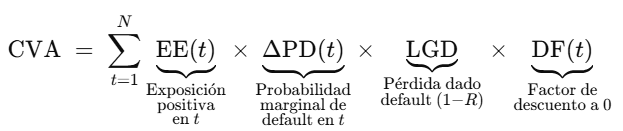

   -En este código, delta_pd * lgd es el vector {ΔPD(t) × LGD}.
   
   -ee_t * (delta_pd * lgd) es el vector {EE(t) × ΔPD(t) × LGD}.
   
   -df_promedio_por_t es el vector{DF(t)}.
   
   -np.dot( … , df_promedio_por_t ) realiza el producto escalar:

   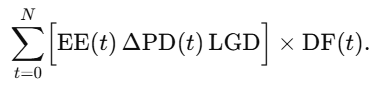

   -Esa suma produce un único número, el CVA estimado para el forward fid.

   -cva_forward[fid] = cva_val, asocia el valor cva_val calculado a la llave fid en cva_forward. Al terminar el bucle, cva_forward contendrá un par clave/valor para cada forward: { fid1: CVA1, fid2: CVA2, … }.

   -Por último, pd.DataFrame.from_dict(cva_forward, orient='index', columns=['CVA']) construye un DataFrame donde el índice son las llaves (los fid) y la única columna se llama “CVA” con los valores correspondientes. Y lo muestra en pantalla.

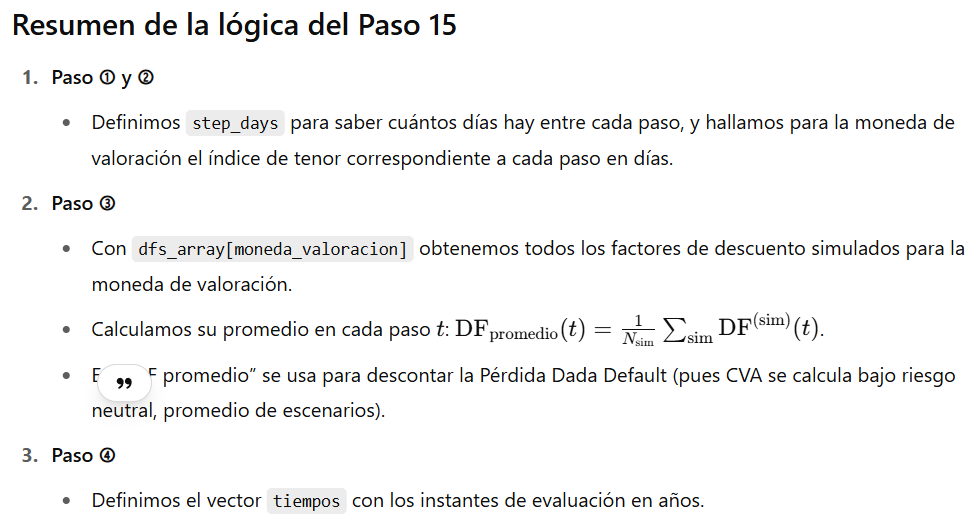

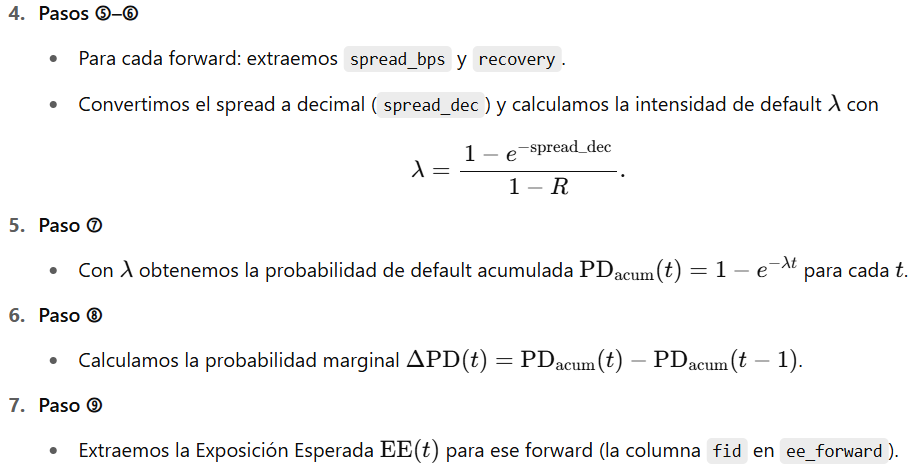

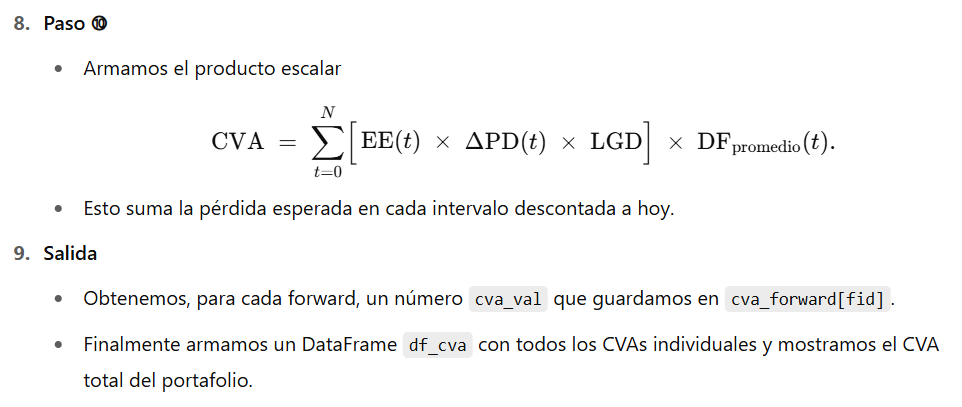

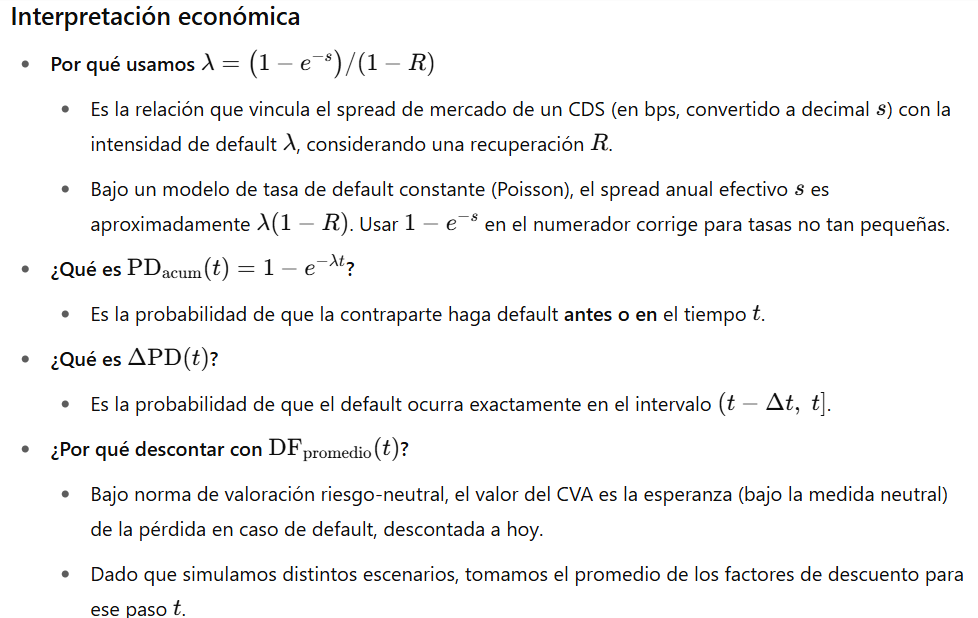

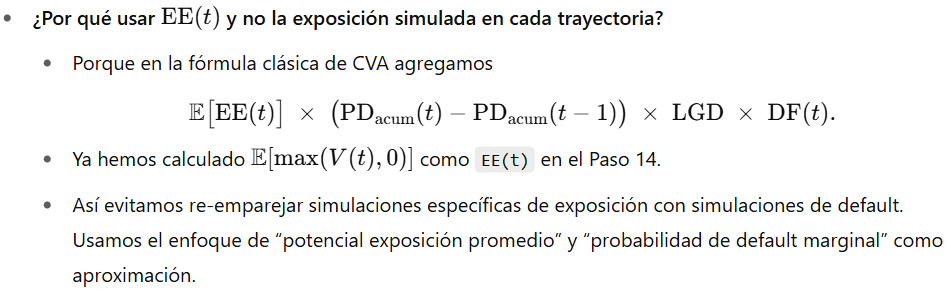

In [ ]:
# Paso 16: Calcular el DVA por forward de forma vectorizada

dva_forward = {}

# ❶ step_days y grid de tiempos
step_days = 365.0 / num_pasos
tiempos = np.linspace(0, horizonte_anios, num_pasos + 1)

# ❷ Vector de índices de tenor para moneda de valoración (ya lo teníamos en Paso 15,
#     pero lo reiteramos aquí para asegurar que esté disponible)
dias_val = dias_por_moneda[moneda_valoracion]
idx_tenor_val_t = []
for t in range(num_pasos + 1):
    tenor_req = int(t * step_days)
    idx = np.abs(dias_val - tenor_req).argmin()
    idx_tenor_val_t.append(idx)

# ❸ Reusar df_promedio_por_t calculado en Paso 15

for _, row in forwards_df.iterrows():
    fid = row['ID']
    spread_bps = float(row['CDS_Propio'])   # spread en bps
    recovery = float(row['Recovery'])       # recuperación R (0–1)
    lgd = 1.0 - recovery

    # ❹ Convertir spread a decimal
    spread_dec = spread_bps / 10000.0

    # ❺ Calcular λ = (1 – e^{–spread}) / (1 – R)
    if recovery >= 1.0:
        raise ValueError(f"Recovery ≥ 1 para forward {fid}: R = {recovery}")
    lam = (1.0 - np.exp(-spread_dec)) / (1.0 - recovery)

    # ❻ Calcular PD acumulada y marginal
    pd_acum = 1.0 - np.exp(-lam * tiempos)         # shape = (num_pasos+1,)
    delta_pd = np.diff(pd_acum, prepend=0.0)       # shape = (num_pasos+1,)

    # ❼ Calcular exposición negativa promedio por paso t
    #     - valores_forward[fid] es un array de shape (num_simulaciones, num_pasos+1)
    neg_array = np.minimum(valores_forward[fid], 0.0)  # shape = (num_simulaciones, num_pasos+1)
    ee_neg_array = neg_array.mean(axis=0)               # shape = (num_pasos+1,)

    # ❽ Calcular DVA con un producto escalar:
    #     DVA = Σ_t [ (- ee_neg_array[t]) * delta_pd[t] * lgd * df_promedio_por_t[t] ]
    dva_val = np.dot((-ee_neg_array) * delta_pd * lgd, df_promedio_por_t)

    dva_forward[fid] = dva_val

# Convertir a DataFrame
df_dva = pd.DataFrame.from_dict(dva_forward, orient='index', columns=['DVA'])

print("\n📉 DVA por forward:")
display(df_dva)

print(f"\n🧮 DVA total del portafolio: {df_dva['DVA'].sum():,.2f}")

1. step_days y grid de tiempos: 

   -step_days = 365.0/num_pasos (~30.4 si num_pasos=12) es el número de días que abarca cada paso mensual.

2. Vector de índices de tenor para moneda de valoración:

   -Índices de tenor para la moneda de valoración. Se repite la construcción de idx_tenor_val_t[t], que en el Paso 15 ya habíamos calculado.
   
   -Para cada paso t, convierto t*step_days a un entero de días y busco en dias_val (los tenores de la curva de valoración) el índice más cercano.
   
   -Esto asegura que, si necesitáramos factorización o algo similar, se tiene el tenor correcto a mano.

3. Reusar df_promedio_por_t calculado en Paso 15:

   -df_promedio_por_t Es el vector {DFprom(𝑡)} que promedia sobre todas las simulaciones los factores de descuento en la moneda de valoración para cada paso t. Se reutiliza aquí directamente.

4. Convertir spread a decimal:

   -Se toma el spread propio (CDS_Propio) en bps, lo convertimos a decimal (spread_dec).

5. Calcular λ = (1 – e^{–spread}) / (1 – R)

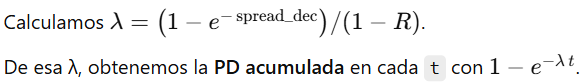

6. Calcular PD acumulada y marginal

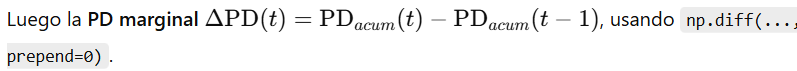

7. Calcular exposición negativa promedio por paso t

   -valores_forward[fid] tiene todas las simulaciones de valor del forward por paso.
   
   -np.minimum(..., 0.0) convierte los valores positivos en 0 y deja los negativos intactos. Así obtenemos solo la parte donde nosotros estaríamos “adeudando” a la contraparte si fuéramos nosotros los que incumplimos.
   
   -Luego mean(axis=0) promedia sobre las simulaciones, dando un vector ee_neg_array[t] = \mathbb{E}[\min(V(t),0)].

8. Calcular DVA con un producto escalar:

   -El DVA se define como la exposición negativa esperada en cada intervalo, multiplicada por la probabilidad marginal de default propia (delta_pd), la LGD y el factor de descuento.
   
   -Como ee_neg_array[t] es negativo o cero, aplicamos (-ee_neg_array) para obtener valores positivos que representen cuánto debemos en caso de default nuestro.
   
   -El producto escalar 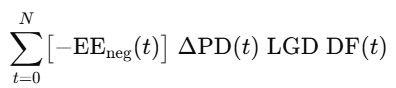

   -El resultado dva_val es el DVA estimado para ese forward, que se guarda en dva_forward[fid].

   -A partir del diccionario dva_forward construimos un DataFrame con índice los IDs de forward y columna “DVA”.
   
   -Luego se muestra el DVA de cada forward y sumamos para obtener el DVA total del portafolio.

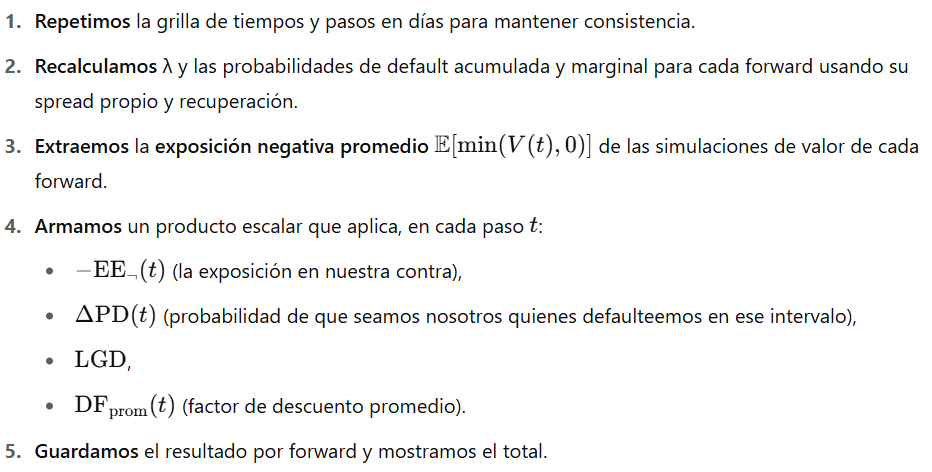

In [ ]:
# Paso 17: Calcular el BVA (CVA - DVA)

# ❶ Obtener orden de forward IDs según el DataFrame original
fids_order = list(forwards_df['ID'])

# ❷ Crear DataFrame vacío con índices fids_order y columnas CVA, DVA
df_bva = pd.DataFrame(index=fids_order, columns=["CVA", "DVA"]).fillna(0.0)

# ❸ Rellenar CVA y DVA desde los diccionarios calculados en pasos previos
for fid in fids_order:
    df_bva.at[fid, "CVA"] = cva_forward.get(fid, 0.0)
    df_bva.at[fid, "DVA"] = dva_forward.get(fid, 0.0)

# ❹ Calcular BVA = CVA - DVA
df_bva["BVA"] = df_bva["CVA"] - df_bva["DVA"]

print("\n🔄 Ajuste Bilateral por forward (BVA = CVA - DVA) (primeros 5 forwards):")
display(df_bva.head(5))

print(f"\n💼 CVA total: {df_bva['CVA'].sum():,.2f}")
print(f"💼 DVA total: {df_bva['DVA'].sum():,.2f}")
print(f"💼 BVA total del portafolio: {df_bva['BVA'].sum():,.2f}")

1. Obtener orden de forward IDs según el DataFrame original:

   -Aquí se extrae la lista de identificadores de forwards (ID) en el mismo orden en que aparecen en forwards_df.
   
   -De este modo el DataFrame final mantiene el orden original de los contratos.

2. Crear DataFrame vacío con índices fids_order y columnas CVA, DVA:

   -Se contruye un DataFrame df_bva con: índice: la lista fids_order, columnas: "CVA" y "DVA".
   
   -Inicialmente todas las celdas contienen NaN; al aplicar .fillna(0.0) las cuales se convierten en ceros.
   
   -Esto deja una estructura con la forma correcta para volcar los valores calculados.

3. Rellenar CVA y DVA desde los diccionarios calculados en pasos previos:

   -Se recorre cada identificador fid en el orden fids_order.
   
   -Para cada uno, se accede a cva_forward[fid] y dva_forward[fid] (donde se guardaron los CVA y DVA de cada forward).
   
   -Se usa .get(fid, 0.0) por si algún contrato no tuviera valor (aunque en teoría todos deberían tenerlo).
   
   -Se asignan esos valores directamente en las celdas correspondientes de df_bva (fila fid, columna "CVA" o "DVA").

4. Calcular BVA = CVA - DVA:

   -Se creó una nueva columna "BVA" que es la diferencia entre CVA y DVA en cada fila.
   
   -El BVA (Bilateral Valuation Adjustment) representa el ajuste neto combinando tanto el riesgo de contraparte (CVA) como el riesgo propio (DVA).

5. Finalmente calculamos y mostramos:

-La suma de todos los CVA individuales (df_bva['CVA'].sum()), que es el CVA agregado del portafolio.

-La suma de todos los DVA (df_bva['DVA'].sum()), es decir, el DVA total.

-La suma de la columna BVA (df_bva['BVA'].sum()), que da el ajuste bilateral neto del portafolio.

In [ ]:
# Paso 18: Estadísticas de tipo de cambio para comparación de mercado

# ❶ Grid de tiempos en años (coincide con EE, CVA/DVA)
tiempos = np.linspace(0, horizonte_anios, num_pasos + 1)

# ❷ Extraer simulaciones de FX para USD/CLP
fx_sim = simulaciones_tc['USD']  # shape = (num_simulaciones, num_pasos+1)

# ❸ Calcular estadísticas: Media, Desviación, Mediana, Percentiles 5% y 95%
mean_fx  = fx_sim.mean(axis=0)
std_fx   = fx_sim.std(axis=0)
med_fx   = np.percentile(fx_sim, 50, axis=0)
p5_fx    = np.percentile(fx_sim, 5,  axis=0)
p95_fx   = np.percentile(fx_sim, 95, axis=0)

# ❹ Construir DataFrame con las estadísticas de FX para cada paso
df_fx_report = pd.DataFrame({
    'Tiempo (años)':             tiempos,
    'Mean_USD/CLP':              mean_fx,
    'Std_USD/CLP':               std_fx,
    'Mediana_USD/CLP':           med_fx,
    'Percentil_5_USD/CLP':       p5_fx,
    'Percentil_95_USD/CLP':      p95_fx
})
df_fx_report.set_index('Tiempo (años)', inplace=True)

print("\n📈 Estadísticas de FX simuladas (primeros 5 pasos):")
display(df_fx_report.iloc[:5])


# Paso 18 (continuación): Preparar curvas promedio y tasas equivalentes

# Asegúrate de que 'dfs_array' y 'dias_por_moneda' estén definidos antes de este bloque.
# Si no, crea 'dfs_array' tal como en Paso 11 y 'dias_por_moneda' como:
# dias_por_moneda = {m: curvas_descuento[m]['Days'].values for m in monedas_unicas}

curvas_promedio = {}  # {moneda: (df_df_prom, df_r_prom)}

for m in monedas_unicas:
    dias = dias_por_moneda[m]         # array de tenores (Days) para esta moneda
    num_tenores = len(dias)

    df_cols = []
    r_cols  = []

    # dfs_array[m] tiene shape = (num_simulaciones, num_pasos+1, num_tenores)
    for t in range(num_pasos + 1):
        df_stack = dfs_array[m][:, t, :]             # (num_simulaciones × num_tenores)

        # 1) DF promedio
        df_promedio = df_stack.mean(axis=0)          # (num_tenores,)
        df_cols.append(df_promedio)

        # 2) Tasa equivalente
        ln_df_mean = np.log(df_stack).mean(axis=0)   # (num_tenores,)
        r_equiv = -ln_df_mean * 365.0 / dias * 100.0  # en %
        r_cols.append(r_equiv)

    pasos_cols = [f"Paso_{t}" for t in range(num_pasos + 1)]

    df_df_prom = pd.DataFrame(
        data = np.column_stack(df_cols),   # (num_tenores × (num_pasos+1))
        columns = pasos_cols
    )
    df_df_prom.insert(0, "Days", dias)

    df_r_prom = pd.DataFrame(
        data = np.column_stack(r_cols),
        columns = pasos_cols
    )
    df_r_prom.insert(0, "Days", dias)

    curvas_promedio[m] = (df_df_prom, df_r_prom)

1. Grid de tiempos en años:

   -Aquí se recrea el arreglo de tiempos en años para cada paso de simulación (de 0 a 1 año, si horizonte_anios=1 y num_pasos=12 → [0,0.0833,…,1.0]).

2. Extraer simulaciones de FX para USD/CLP:

   -Se selecciona la matriz de trayectorias simuladas de USD/CLP. Cada fila es una simulación, cada columna un paso.

3. Calcular estadísticas: Media, Desviación, Mediana, Percentiles 5% y 95%:

   -Se calcula cinco métricas en cada paso 𝑡:
   
   -Media 𝐸[𝑆𝑡]
   
   -Desviación estándar
   
   -Mediana (= percentil 50)
   
   -Percentil 5 (escenario pesimista)
   
   -Percentil 95 (escenario optimista)

4. Construir DataFrame con las estadísticas de FX para cada paso:

   -Se monta un DataFrame donde cada fila corresponde a un paso temporal (Tiempo (años)), y las columnas son esas cinco estadísticas.

5. Se prepara un diccionario vacío donde guardarás, para cada moneda, dos DataFrames:

   -df_df_prom con los factores de descuento promedio
   
   -df_r_prom con las tasas equivalentes promedio

6. Para cada moneda m haces un bucle sobre los pasos t:

   -Extraes df_stack, que es la matriz de factores de descuento simulados en ese paso para todos los tenores.

   -Promedias a lo largo de las simulaciones (.mean(axis=0)) para obtener df_promedio, un vector de longitud num_tenores.

   -Calculas la tasa equivalente r_equiv a partir del promedio de ln(DF).

   -Acumulas ambos vectores en las listas df_cols y r_cols.

7. Después de llenar df_cols y r_cols, apilas sus vectores en columnas (con np.column_stack) para construir:

   -df_df_prom: DataFrame de factores de descuento
   
   -df_r_prom: DataFrame de tasas equivalentes (en %)
   
   -En ambos insertas primero la columna "Days" con los tenores originales

8. Guardas la tupla (df_df_prom, df_r_prom) en curvas_promedio[m].

In [ ]:
# Paso 19: Exportar a Excel

nombre_archivo = "reporte_CVA_DVA_BVA.xlsx"
ruta_completa = os.path.abspath(nombre_archivo)

if os.path.exists(ruta_completa):
    print(f"\n📢 Advertencia: el archivo {ruta_completa} ya existe y será sobrescrito.")

with pd.ExcelWriter(ruta_completa, engine="xlsxwriter") as writer:
    # 1) Resumen BVA
    df_bva.to_excel(writer, sheet_name="CVA_DVA_BVA", index=True)

    # 2) Exposición Esperada
    ee_forward.to_excel(writer, sheet_name="Exposicion_Esperada", index=True)

    # 3) Valor Forward Promedio
    valores_forward_df.to_excel(writer, sheet_name="Valor_Forward_Esperado", index=True)

    # 4) Estadísticas de FX simuladas (para comparar con mercado)
    df_fx_report.to_excel(writer, sheet_name="FX_Simuladas", float_format="%.6f")

    # 5) Curvas promedio y tasas equivalentes para cada moneda
    for m in monedas_unicas:
        df_df_prom, df_r_prom = curvas_promedio[m]
        hoja_df = f"Curva_{m}"[:31]
        hoja_r  = f"Tasa_{m}"[:31]
        df_df_prom.to_excel(writer, sheet_name=hoja_df, index=False, float_format="%.8f")
        df_r_prom.to_excel(writer, sheet_name=hoja_r,   index=False, float_format="%.6f")

print(f"\n📁 Reporte guardado exitosamente en:\n{ruta_completa}")


1. Se exportan todos los resultados a un Excel para poder verlos de manera más fácil y se muestra la ruta en la que está.